In [245]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np
import pandas as pd
import scipy.stats as stats
import math
from scipy.stats import binom,poisson,norm,beta,gamma
from scipy import stats


# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [246]:
# just user for bell distribution update in future
def hdi(point,prob,ci=0.9): 
    hdi_df = pd.DataFrame(data={
        'point': point,
        'prob': prob
    })
    hdi_df = hdi_df.sort_values(by='prob',ascending=False)
    cum_prob = 0 

    max_row = hdi_df.iloc[0,:]

    quantile = np.Inf
    opp_quantile = np.Inf
    sign = np.Inf

    for i in range(0,len(hdi_df)):
        
        if cum_prob < ci:
         cum_prob = cum_prob + hdi_df.iloc[i,:].prob

        if (cum_prob >= ci) and (quantile == np.Inf):
            quantile = hdi_df.iloc[i,:].point
            sign = quantile - max_row.point
        
        if (cum_prob >= ci) and (sign != np.Inf):
            curr_sign = hdi_df.iloc[i,:].point - max_row.point
            if(curr_sign/np.abs(curr_sign) != sign/np.abs(sign)):
                # found hdi
                 opp_quantile = hdi_df.iloc[i,:].point
                 return np.sort([quantile,opp_quantile])
    


In [247]:
hvn = pd.read_csv("./New-HVN-Fix-Outlier.csv")
hvn["Time"] = pd.to_datetime(hvn["Time"], infer_datetime_format=True)
hvn.set_index("Time", inplace=True)
hvn = hvn[::-1]

----
##  Phân tích bayes trên bộ dữ liệu phân ở dạng phối chuẩn

###  Chuyển dữ liệu qua phân phối chuẩn

In [248]:
hvn["Difference"].describe()

count     902.000000
mean      -22.510245
std       509.244885
min     -1798.815661
25%      -277.000000
50%       -40.000000
75%       200.000000
max      1736.903023
Name: Difference, dtype: float64

<AxesSubplot:xlabel='Difference', ylabel='Count'>

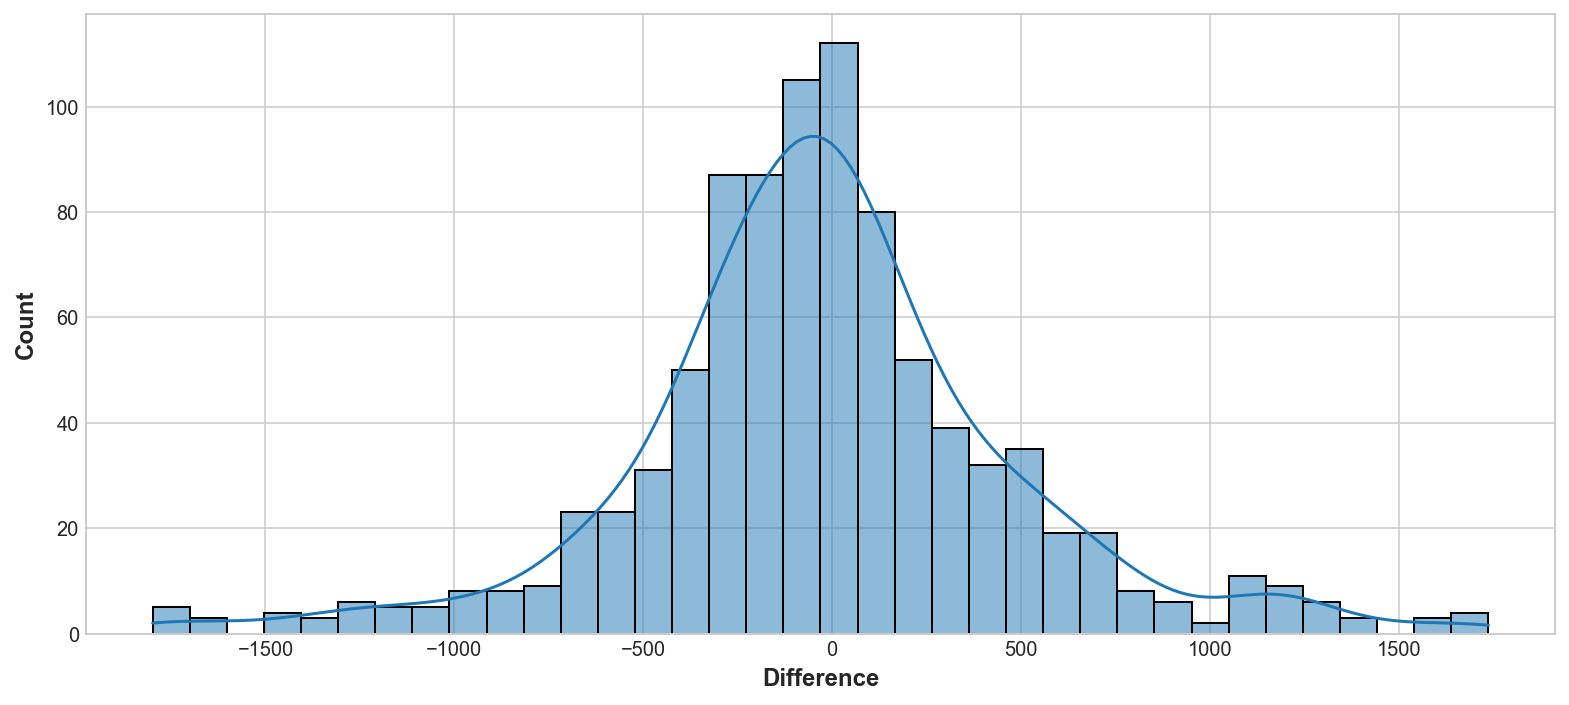

In [249]:
sns.histplot(hvn['Difference'], kde=True)

Ý nghĩa của bộ dữ liệu sau khi đã lấy sai phân là nó đánh giá việc giá của cổ phiếu HVN giao động như thế
nào, trong 1 ngày giá có thể thay đổi từ giảm bao nhiêu đến tăng bao nhiêu. Qua phân tích ta thấy sự thay đổi của của cổ phiếu HVN trong giai đoạn 2019 tới 2022 
giá giảm mức lớn nhất là -1798, tăng cao nhất là 1736 với trung bình là -22.5 tức trong giai đoạn 
này mỗi ngày HVN giảm tầm -22 đồng, hơn 50% quan sát là có giá trị dưới -40.

### Phân tích bayes cho biến động giá HVN  
Ở đây ta sẽ bộ dữ liệu thành 3 phần sau đó dùng posterior ở cuối mỗi giai đoạn làm đầu vào 
prior cho giai đoạn tiếp theo. ![](./src/intro.png)

In [250]:
hvn_1 = hvn[0:301]
hvn_2 = hvn[0:602]
hvn_3 = hvn[0:903]

In [251]:
hvn_1['Difference'].describe()

count     301.000000
mean      -49.833887
std       451.038401
min     -1750.000000
25%      -250.000000
50%         0.000000
75%       150.000000
max      1700.000000
Name: Difference, dtype: float64

Xem bộ dữ liệu giai đoạn 1 từ 8-5-2019 tới 15-7-2020 có trung bình -22 và độ lệch chuẩn 
là 451.  

- Do bộ dữ liệu của chúng là phân phối chuẩn cho nên nhóm sẽ chọn đầu tiên nghiệm (prior)
là phân phối chuẩn với trung bình bằng 0 (do giả định các giá trị giao động tăng giảm sẽ luôn bằng 0) và phương sai là 451^2 g(μ) ~ norm(m,s^2).  
- Giá trị các trung bình (μ) sẽ là rời rạc trong khoảng từ âm độ lệch chuẩn * 1.196 đến dương độ lệch chuẩn * 1.96. Được chia thành 
1000 điểm cách đều nhau bằng hàm linespace.
- **Prior** sẽ được tính bằng hàm hàm mật độ xác suất (pdf) của phân phối chuẩn với trung bình là 0 độ lệch chuẩn là 754.
- **Likelihood** sẽ được tính bằng hàm hàm mật độ xác suất (pdf) cho nhiều điểm quan sát  của phân phối chuẩn, với trung bình là μ độ lệch chuẩn là 451 chia cho căn bậc 2 của số quan sát. ![](./src/1.png)
- **Posterior** sẽ được tính toán thủ công, không sử dụng công thức của tiên nghiệm liên hợp.

##### (STAGE 1) Khởi tạo các tham số ở giai đoạn 1 từ 8-5-2019 tới 15-7-2020

In [252]:
m = 0
s = 451
sigma = 451
# tạo dataframe
norm_bayes_df_stage_1  = pd.DataFrame()
# tạo các trung bình miu
lower = hvn_1["Difference"].mean() - 1.96*hvn_1["Difference"].std()
upper = hvn_1["Difference"].mean() + 1.96*hvn_1["Difference"].std()
mu_es = np.linspace(lower, upper, 1000)
norm_bayes_df_stage_1['mu'] = mu_es
# tính xác suát cho prior với phân phối norm(m,s^2)
norm_bayes_df_stage_1['prior'] = norm.pdf(norm_bayes_df_stage_1['mu'],loc=m,scale=s)
# tính likelihood
norm_bayes_df_stage_1['likelihood'] = norm.pdf(hvn_1["Difference"].mean(),loc= norm_bayes_df_stage_1['mu'],scale= sigma / np.sqrt(len(hvn_1)))
# tính posterior
norm_bayes_df_stage_1['joint'] =  norm_bayes_df_stage_1['prior'] * norm_bayes_df_stage_1['likelihood']
norm_bayes_df_stage_1['posterior'] = norm_bayes_df_stage_1['joint']  / sum(norm_bayes_df_stage_1['joint'])
norm_bayes_df_stage_1[515:530]

,mu,prior,likelihood,joint,posterior
515,-22.401361,0.000883,0.008794,0.000008,0.015666
516,-20.631521,0.000884,0.008166,0.000007,0.014549
517,-18.861681,0.000884,0.007547,0.000007,0.013449
518,-17.091840,0.000884,0.006943,0.000006,0.012374
519,-15.322000,0.000884,0.006357,0.000006,0.011332
520,-13.552159,0.000884,0.005794,0.000005,0.010330
521,-11.782319,0.000884,0.005257,0.000005,0.009373
522,-10.012479,0.000884,0.004747,0.000004,0.008465
523,-8.242638,0.000884,0.004267,0.000004,0.007610
524,-6.472798,0.000884,0.003818,0.000003,0.006809


Text(0.5, 1.0, 'Stage 1')

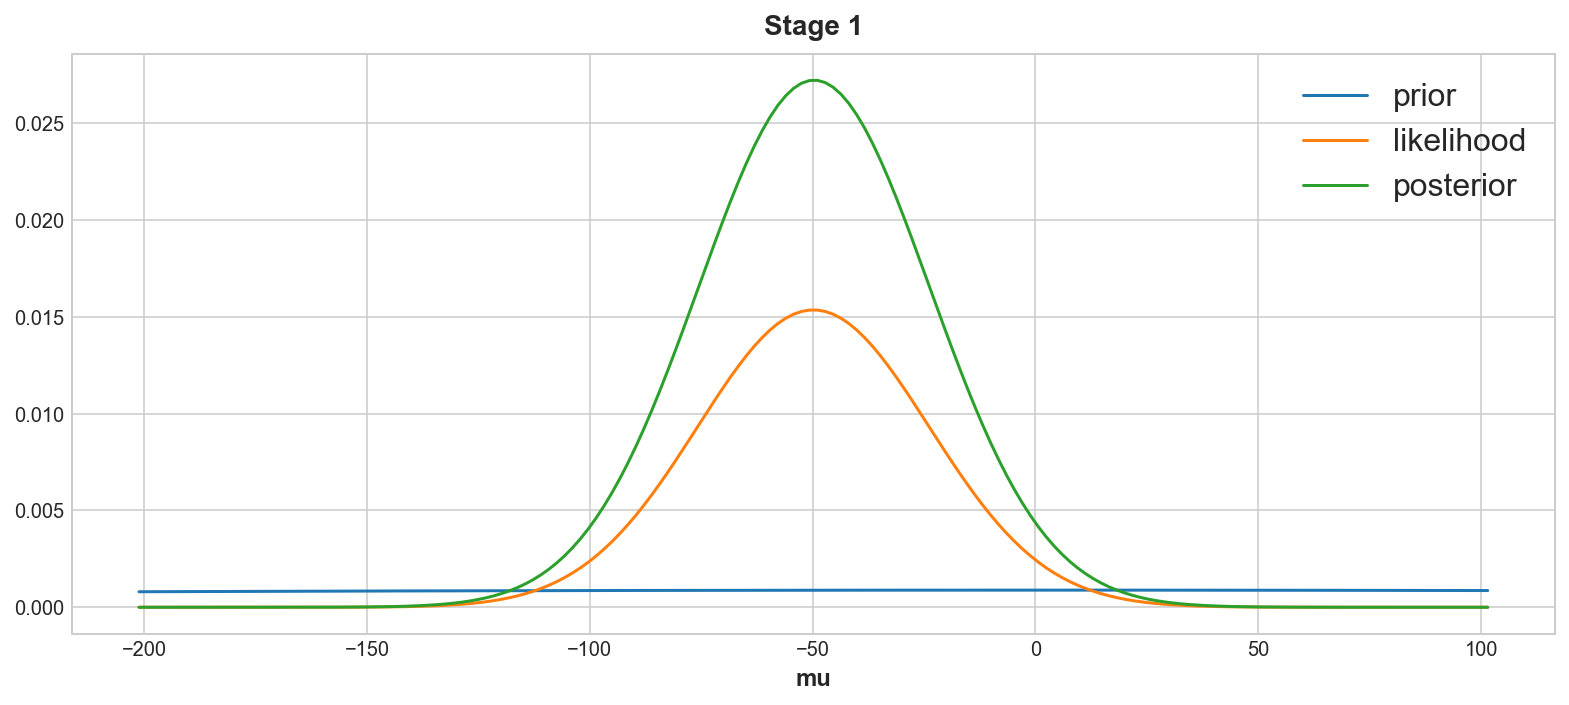

In [253]:
plot_data = norm_bayes_df_stage_1.set_index('mu')[['prior','likelihood','posterior']]

plot_data = plot_data[plot_data['posterior'] > 0.000000001]
plot_data.plot()
plt.title('Stage 1')


##### (STAGE 2)  Tiếp tục tính toán ở giai đoạn 2 từ 8-5-2019 tới 27-9-2021

In [254]:
# sử dụng posterior giai đoạn 1 làm đầu vào prior cho giai đoạn 2
norm_bayes_df_stage_2 = pd.DataFrame()
norm_bayes_df_stage_2['mu'] = mu_es
norm_bayes_df_stage_2['prior'] = norm_bayes_df_stage_1['posterior']
# tính likelihood
norm_bayes_df_stage_2['likelihood'] = norm.pdf(hvn_2["Difference"].mean(),loc= norm_bayes_df_stage_2['mu'],scale= sigma / np.sqrt(len(hvn_2)))
# tinh posterior
norm_bayes_df_stage_2['joint'] =  norm_bayes_df_stage_2['prior'] * norm_bayes_df_stage_2['likelihood']
norm_bayes_df_stage_2['posterior'] = norm_bayes_df_stage_2['joint']  / sum(norm_bayes_df_stage_2['joint'])#
norm_bayes_df_stage_2[515:530]

,mu,prior,likelihood,joint,posterior
515,-22.401361,0.015666,0.020899,0.000327,0.043742
516,-20.631521,0.014549,0.021360,0.000311,0.041520
517,-18.861681,0.013449,0.021630,0.000291,0.038865
518,-17.091840,0.012374,0.021701,0.000269,0.035877
519,-15.322000,0.011332,0.021572,0.000244,0.032662
520,-13.552159,0.010330,0.021246,0.000219,0.029323
521,-11.782319,0.009373,0.020731,0.000194,0.025961
522,-10.012479,0.008465,0.020042,0.000170,0.022668
523,-8.242638,0.007610,0.019197,0.000146,0.019518
524,-6.472798,0.006809,0.018218,0.000124,0.016574


Đồ thị prior,likelihood và posterior

Text(0.5, 1.0, 'Stage 2')

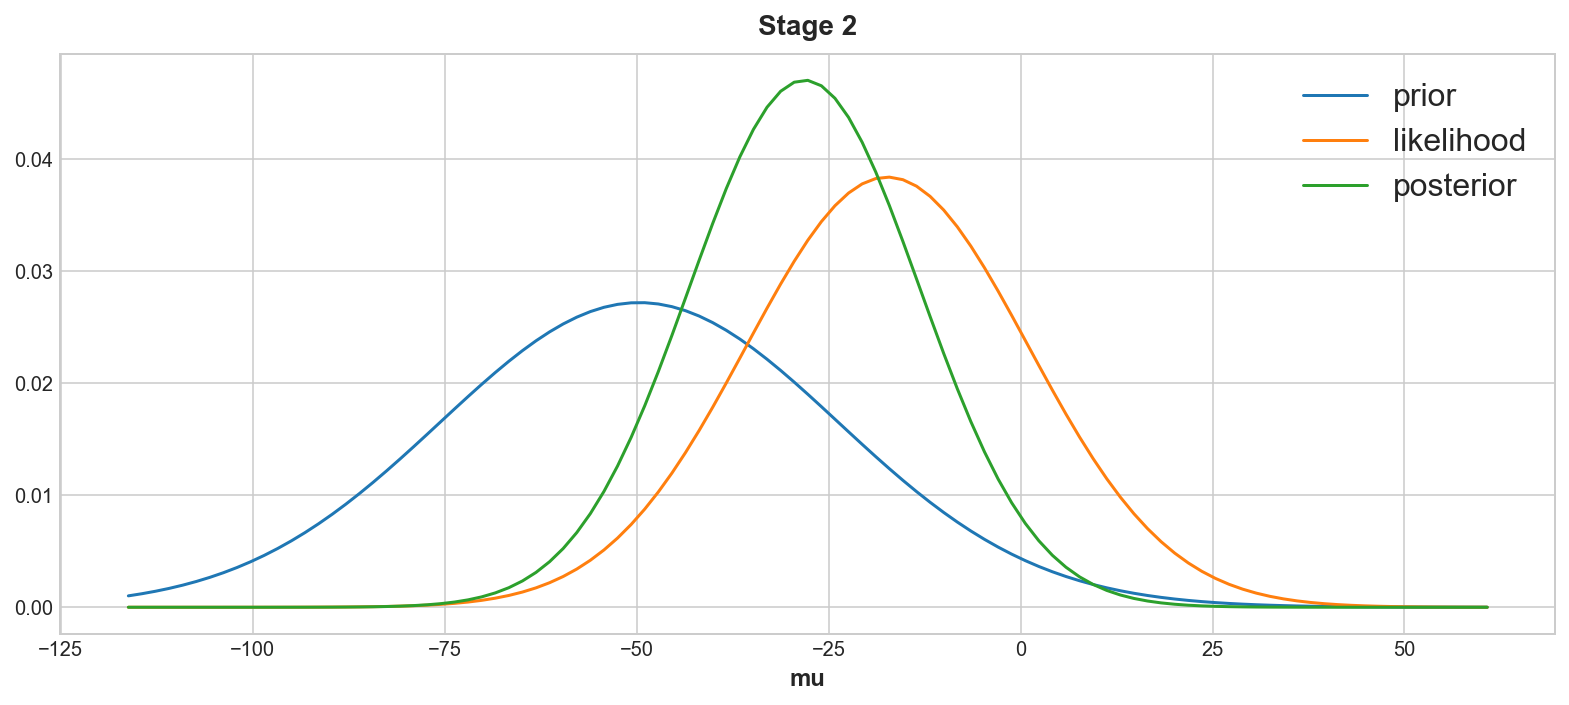

In [255]:
plot_data = norm_bayes_df_stage_2.set_index('mu')[['prior','likelihood','posterior']]


plot_data['prior'] = plot_data['prior'] / sum(plot_data['prior'])
plot_data['likelihood'] = plot_data['likelihood'] / sum(plot_data['likelihood'])

plot_data = plot_data[plot_data['posterior'] > 0.000000001]


plot_data.plot()
plt.title('Stage 2')

##### (STAGE 3) Cuối cùng tính toán ở giai đoạn 3 từ 8-5-2019 tới 27-9-2021

In [256]:
# sử dụng posterior giai đoạn 2 làm đầu vào prior cho giai đoạn 3
norm_bayes_df_stage_3 = pd.DataFrame()
norm_bayes_df_stage_3['mu'] = mu_es
norm_bayes_df_stage_3['prior'] = norm_bayes_df_stage_2['posterior']
# tính likelihood
norm_bayes_df_stage_3['likelihood'] = norm.pdf(hvn_3["Difference"].mean(),loc= norm_bayes_df_stage_3['mu'],scale= sigma / np.sqrt(len(hvn_3)))
# tinh posterior
norm_bayes_df_stage_3['joint'] =  norm_bayes_df_stage_3['prior'] * norm_bayes_df_stage_3['likelihood']
norm_bayes_df_stage_3['posterior'] = norm_bayes_df_stage_3['joint']  / sum(norm_bayes_df_stage_3['joint'])
norm_bayes_df_stage_3[515:530]

,mu,prior,likelihood,joint,posterior
515,-22.401361,0.043742,0.026566,0.001162,0.064044
516,-20.631521,0.041520,0.026360,0.001094,0.060317
517,-18.861681,0.038865,0.025794,0.001002,0.055249
518,-17.091840,0.035877,0.024892,0.000893,0.049219
519,-15.322000,0.032662,0.023691,0.000774,0.042645
520,-13.552159,0.029323,0.022236,0.000652,0.035935
521,-11.782319,0.025961,0.020583,0.000534,0.029450
522,-10.012479,0.022668,0.018790,0.000426,0.023474
523,-8.242638,0.019518,0.016917,0.000330,0.018197
524,-6.472798,0.016574,0.015020,0.000249,0.013719


Đồ thị prior,likelihood và posterior

Text(0.5, 1.0, 'Stage 3')

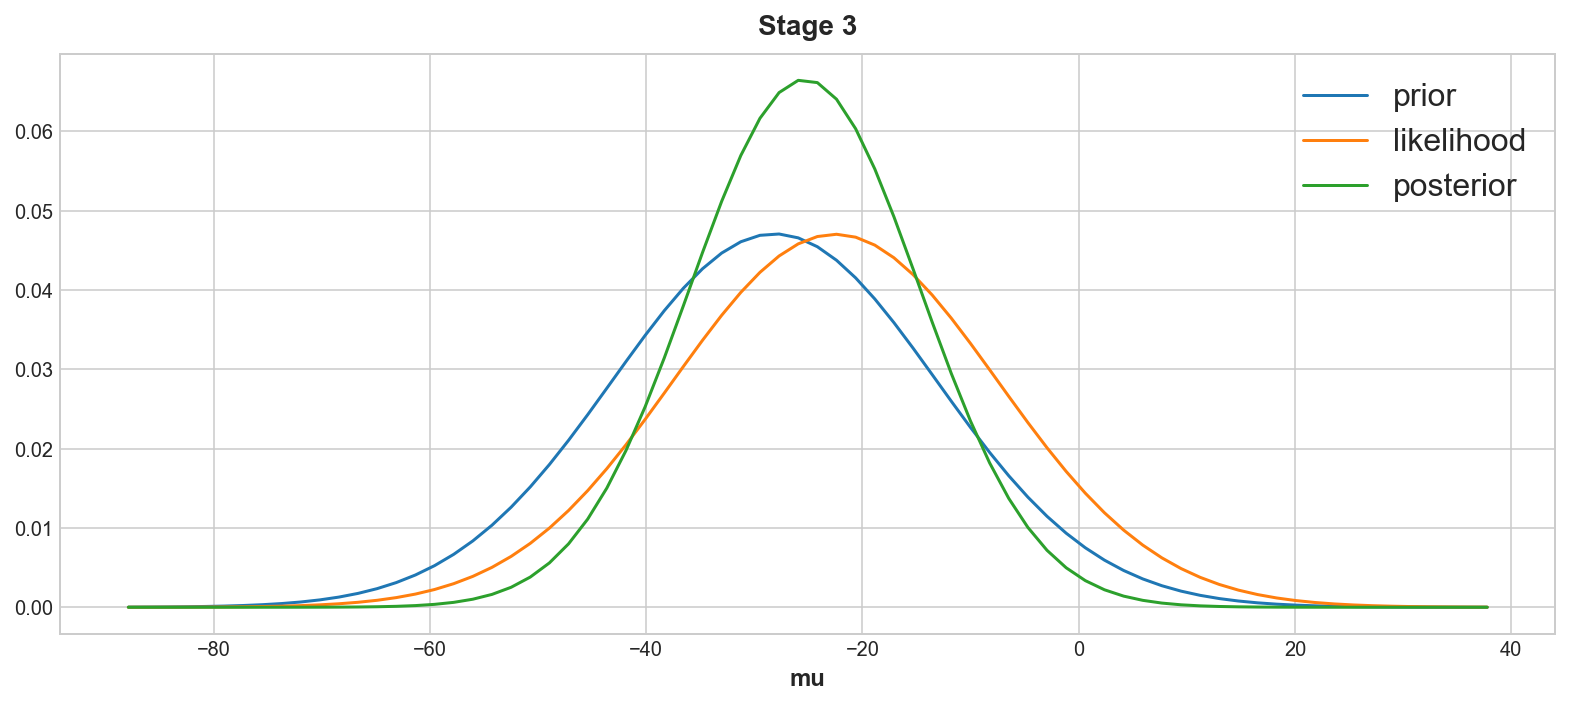

In [257]:
plot_data = norm_bayes_df_stage_3.set_index('mu')[['prior','likelihood','posterior']]


plot_data['prior'] = plot_data['prior'] / sum(plot_data['prior'])
plot_data['likelihood'] = plot_data['likelihood'] / sum(plot_data['likelihood'])

plot_data = plot_data[plot_data['posterior'] > 0.000000001]
plot_data.plot()
plt.title('Stage 3')

### Đồ thị của Posterior

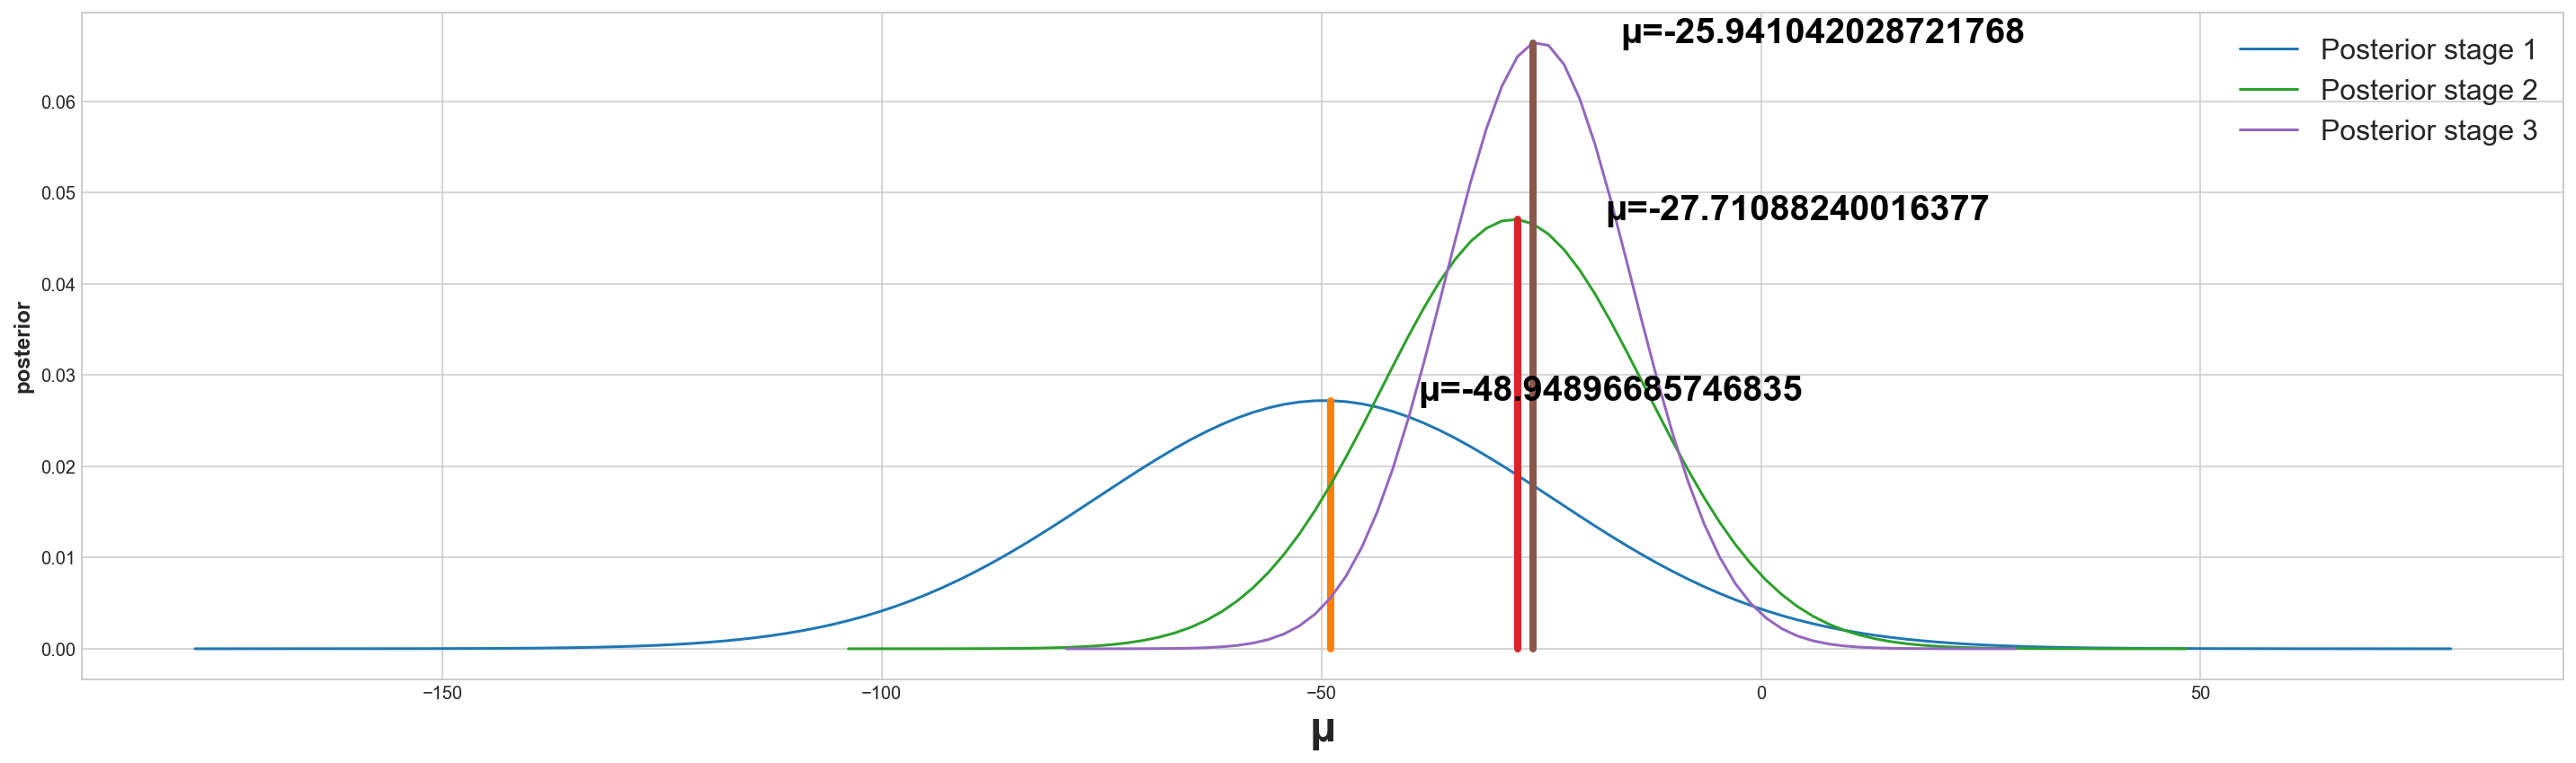

In [258]:
# Plotting all three together
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(20,6))
plt.xlabel('μ', fontsize=24)
stages = [norm_bayes_df_stage_1,norm_bayes_df_stage_2,norm_bayes_df_stage_3]

max_mu_list = []

for i in range(0,3): 
     data = stages[i].drop(columns=['joint','likelihood','prior'])
     data = data[data['posterior'] > 0.0000001] 
    
     max_mu = data[data['posterior'] >= data['posterior'].max()] 
     max_mu_list.append(max_mu)

     curr_mu = max_mu['mu'].values[0]
     curr_posterior = max_mu['posterior'].values[0]

     sns.lineplot(x=data['mu'],y=data['posterior'],ax=axes,label='Posterior stage {}'.format(i+1))
     axes.plot([curr_mu,curr_mu],[0,curr_posterior], linewidth=4, )
     axes.text(curr_mu + 10,curr_posterior,s='μ={}'.format(curr_mu),horizontalalignment='left', size='20', color='black', weight='semibold')

plt.rc('legend',fontsize=16)
plt.show()

*Các giá trị μ ở xa 0 tức 2 đuôi có giá trị xác xuất quá thấp nên đã bị loại ra khỏi đồ thị.* 
 
Qua các giai đoạn phân phối posterior của giai đoạn cuối (3) có xu hướng di chuyển và hội tụ ở trung bình -25 ,phương sai nhỏ dần. 
Tính chất giống như thống kê tần suất , với lượng quan sát lớn phương sai sẽ nhỏ dần.

### Khoảng tin cậy (credible interval) và kiểm định


Ở đây nhóm sử dụng chỉ số HDI (high density interval) với mức tin tưởng 90%  thay vì ETI (Equal-tailed Interval) để kiểm tra xem
giá biến động của cổ phiếu HVN có khả năng ở mức nào.

In [259]:
# tính hid
[hdi_lower, hdi_upper] = hdi(norm_bayes_df_stage_3['mu'],norm_bayes_df_stage_3['posterior']) 
print("Cận dưới HDI {} \nCận trên HDI {}".format(hdi_lower,hdi_upper))

Cận dưới HDI -43.63944574314223 
Cận trên HDI -8.242638314301189


Text(0.5, 0, 'μ')

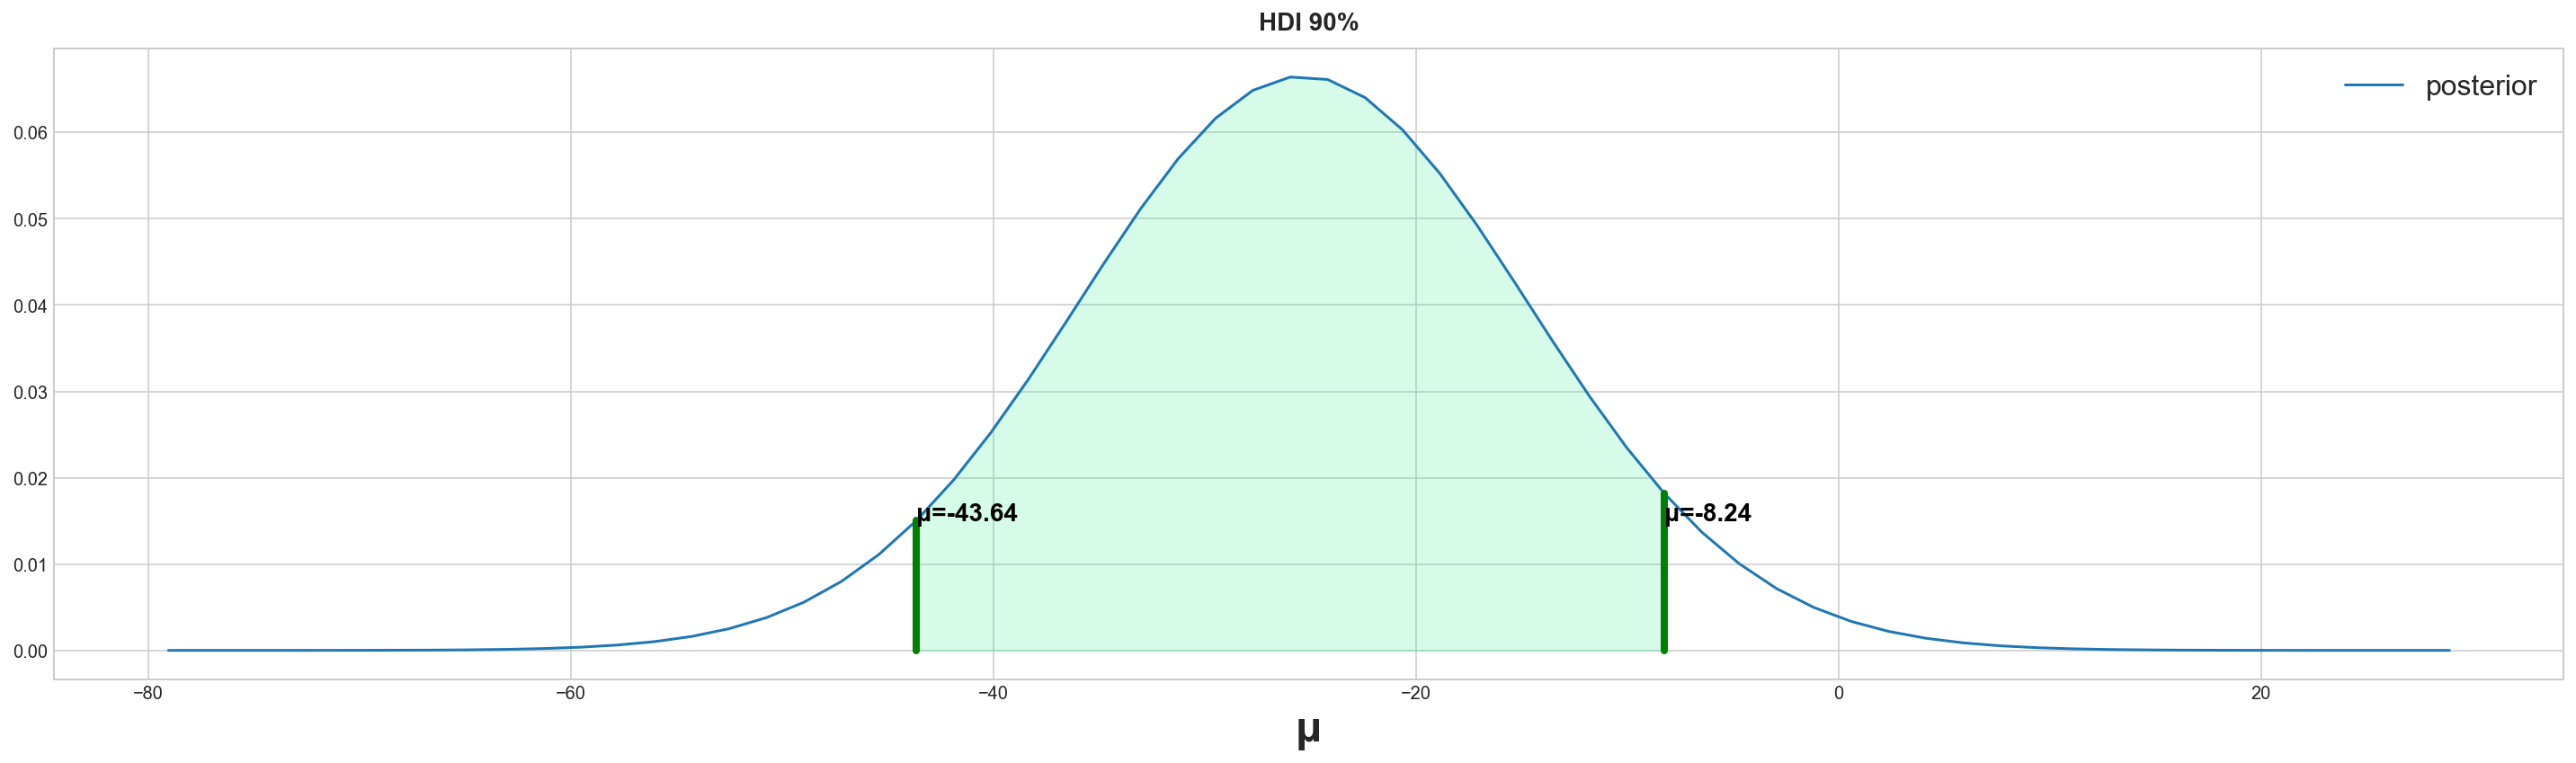

In [260]:
plot_data = norm_bayes_df_stage_3.set_index('mu')[['posterior']]
plot_data = plot_data[plot_data['posterior'] > 0.0000001]

plot_data = plot_data.sort_values(by='mu')

fill_data = plot_data[plot_data.index >= hdi_lower]

fill_data = fill_data[fill_data.index <= hdi_upper]

hdi_lower_prob = fill_data[fill_data.index == hdi_lower].iloc[0,:]['posterior']

hdi_upper_prob = fill_data[fill_data.index == hdi_upper].iloc[0,:]['posterior']

fig, axes = plt.subplots(1, 1, sharex=True, figsize=(20,6))

axes.fill_between(fill_data.index,fill_data['posterior'],alpha=0.2,color='#33eb91')
plt.title('HDI 90%')
plot_data.plot(ax=axes)
# chú thích cho HDI 
axes.plot([hdi_lower,hdi_lower],[0,hdi_lower_prob], linewidth=4,color='green')
axes.plot([hdi_upper,hdi_upper],[0,hdi_upper_prob], linewidth=4,color='green')
axes.text(hdi_lower + 0.002,hdi_lower_prob,s='μ={}'.format(np.round(hdi_lower,2)),horizontalalignment='left', size='14', color='black', weight='semibold')
axes.text(hdi_upper + 0.002,hdi_lower_prob,s='μ={}'.format(np.round(hdi_upper,2)),horizontalalignment='left', size='14', color='black', weight='semibold')

plt.xlabel('μ', fontsize=24)


Kỉểm đinh giá trị của μ cặp giả thuyết
- H0: μ = -50
- H1: μ != -50  
- Ta có μ nằm ngoài miền HDI cho nên bác bỏ H0 kết luận μ != -50


Kiểm định khoảng với cặp giả thuyết với độ tin cậy 90%
- H0: μ <= -100
- H1: μ > -100

In [261]:
# Tính suát xuất tích lũy của posterior với μ <= -100
hypothesis_df = norm_bayes_df_stage_3[['mu','posterior']].sort_values(by='mu')
p_value = sum(hypothesis_df[hypothesis_df['mu'] <= -100]['posterior'])
p_value <= 0.05


True

p_value bé hơn 5% cho nên bắc bỏ H0 chấp nhận H1 μ > -100

--------------------
##  Phân tích bayes trên bộ dữ liệu phân ở dạng nhị thức

###  Chuyển dữ liệu qua phân nhị thức

Tỉ lệ có phiếu tằng giá: 0.4246119733924612 
Phôi phối nhị thức với trung bình : 383.0 
Phôi phối nhị thức với độ lệch chuẩn: 14.844986163371368 


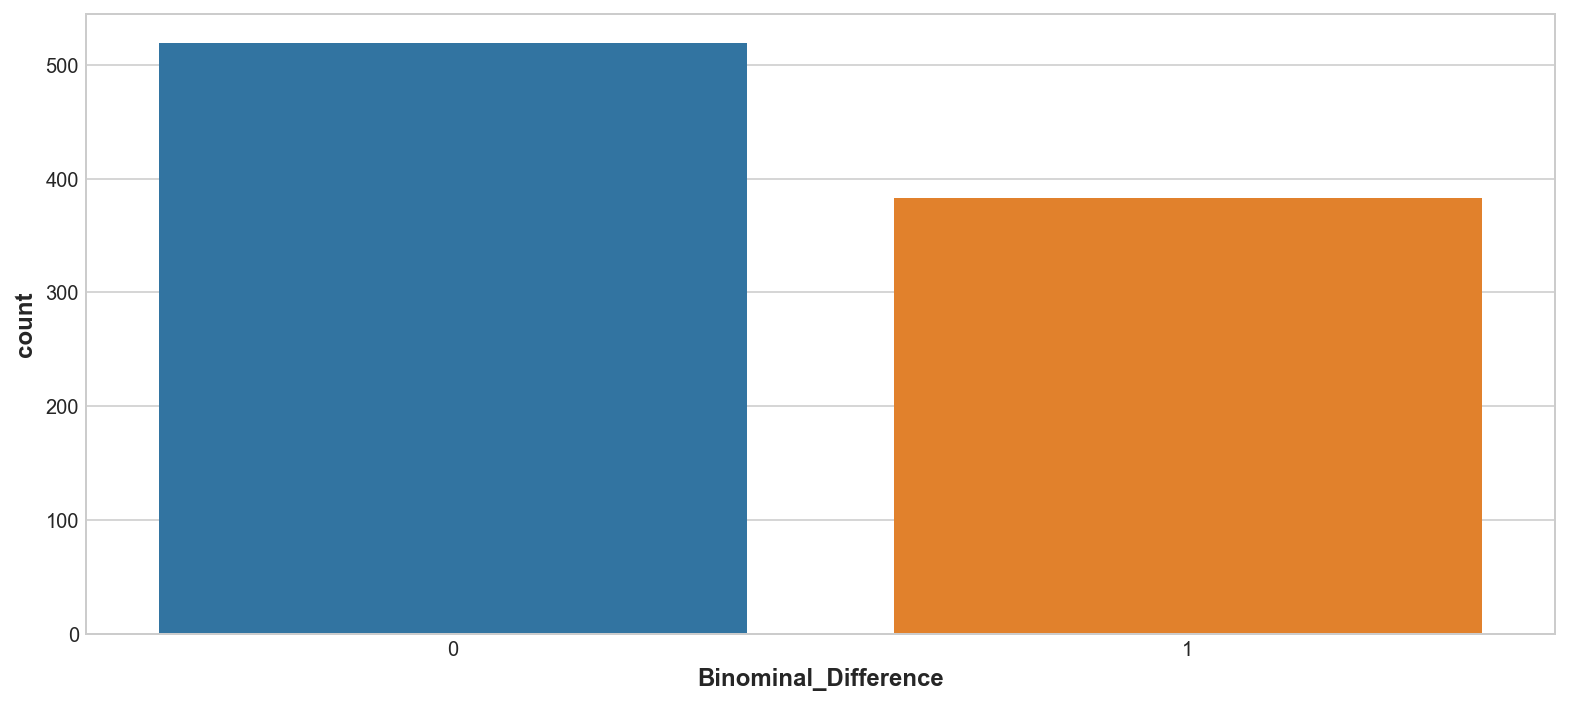

In [262]:
hvn["Binominal_Difference"] = hvn["Difference"]>0
hvn.replace(True, 1, inplace=True)
hvn.replace(False, 0, inplace=True)
sns.countplot(data=hvn,x='Binominal_Difference')

up_price_ratio = sum(hvn["Binominal_Difference"]) / len(hvn["Binominal_Difference"])
total_mean = len(hvn) * up_price_ratio
total_std = np.sqrt(len(hvn) * up_price_ratio * (1 - up_price_ratio))

print('Tỉ lệ có phiếu tằng giá: {} '.format(up_price_ratio))
print('Phôi phối nhị thức với trung bình : {} '.format(total_mean))
print('Phôi phối nhị thức với độ lệch chuẩn: {} '.format(total_std))

### Phân tích bayes cho tỉ lệ tăng giá HVN  
Ở đây ta sẽ bộ dữ liệu thành 3 phần sau đó dùng posterior ở cuối mỗi giai đoạn làm đầu vào 
prior cho giai đoạn tiếp theo. ![](./src/intro.png)

In [263]:
hvn_1 = hvn[0:301]
hvn_2 = hvn[0:602]
hvn_3 = hvn[0:903]

In [264]:
up_price_ratio_stage_1 = sum(hvn_1["Binominal_Difference"]) / len(hvn_1["Binominal_Difference"])
stage_1_mean = len(hvn_1) * up_price_ratio_stage_1
stage_1_std = np.sqrt(len(hvn_1) * up_price_ratio_stage_1 * (1 - up_price_ratio_stage_1))

print('Tỉ lệ có phiếu tằng giá: {} '.format(up_price_ratio_stage_1))
print('Phân phối nhị thức với trung bình : {} '.format(stage_1_mean))
print('Phân phối nhị thức với độ lệch chuẩn: {} '.format(stage_1_std))

Tỉ lệ có phiếu tằng giá: 0.4418604651162791 
Phân phối nhị thức với trung bình : 133.0 
Phân phối nhị thức với độ lệch chuẩn: 8.615831830968784 


chia 2, với ý đồ là sát suất tăng giá là 0.5 tương đương sát suất tung đồng coin.
- Giá trị các tỷ lệ (π) sẽ là rời rạc trong khoảng từ 0 đến 1. Được chia thành 
1000 điểm cách đều nhau bằng hàm linespace.
- **Prior** bởi vì giá trị của hàm CDF beta lớn, nên ta có thể dùng cách tính sắp sỉ của máy tính, tính bằng cách lấy hàm tích lũy xác suất (cdf) của π + e trừ cho tính lũy xác (cdf)  của π của phân phối beta(a,b) , với e <= 0.0001.
- **Likelihood** sẽ được tính bằng hàm pmf (xác xuát tại điểm) của phân phối nhị thức  vớixác suất thành công là π. ![](./src/2.png)
- **Posterior** sẽ được tính toán thủ công, không sử dụng công thức của tiên nghiệm liên hợp.

##### (STAGE 1) Khởi tạo các tham số ở giai đoạn 1 từ 8-5-2019 tới 15-7-2020

In [265]:
a = np.floor(len(hvn_1) / 2)
b = a
pi_s = np.linspace(0,1,1000)

e = 0.0001
# tạo dataframe
bio_bayes_df_stage_1 = pd.DataFrame()
# các pi được lựa chọn
bio_bayes_df_stage_1['pi'] = pi_s
# tính prior
bio_bayes_df_stage_1['prior'] = np.array(beta.cdf(a=a,b=b,x=bio_bayes_df_stage_1['pi'].map(lambda pi : pi + e))) - np.array(beta.cdf(a=a,b=b,x=bio_bayes_df_stage_1['pi']))
# tính likelihood
bio_bayes_df_stage_1['likelihood'] = binom.pmf(k=sum(hvn_1['Binominal_Difference']),
n=len(hvn_1['Binominal_Difference']),p=bio_bayes_df_stage_1['pi'])
# tính posterior
bio_bayes_df_stage_1['joint'] =  bio_bayes_df_stage_1['prior'] * bio_bayes_df_stage_1['likelihood']
bio_bayes_df_stage_1['posterior'] = bio_bayes_df_stage_1['joint']  / sum(bio_bayes_df_stage_1['joint'])

bio_bayes_df_stage_1[410:425]

,pi,prior,likelihood,joint,posterior
410,0.410410,0.000011,0.025116,2.696971e-07,0.000228
411,0.411411,0.000012,0.026102,3.127936e-07,0.000265
412,0.412412,0.000013,0.027093,3.618397e-07,0.000306
413,0.413413,0.000015,0.028085,4.174973e-07,0.000353
414,0.414414,0.000017,0.029077,4.804765e-07,0.000407
415,0.415415,0.000018,0.030066,5.515360e-07,0.000467
416,0.416416,0.000020,0.031049,6.314819e-07,0.000535
417,0.417417,0.000023,0.032024,7.211660e-07,0.000610
418,0.418418,0.000025,0.032988,8.214836e-07,0.000695
419,0.419419,0.000028,0.033938,9.333699e-07,0.000790


Đồ thị prior,likelihood và posterior

Text(0.5, 1.0, 'Stage 1')

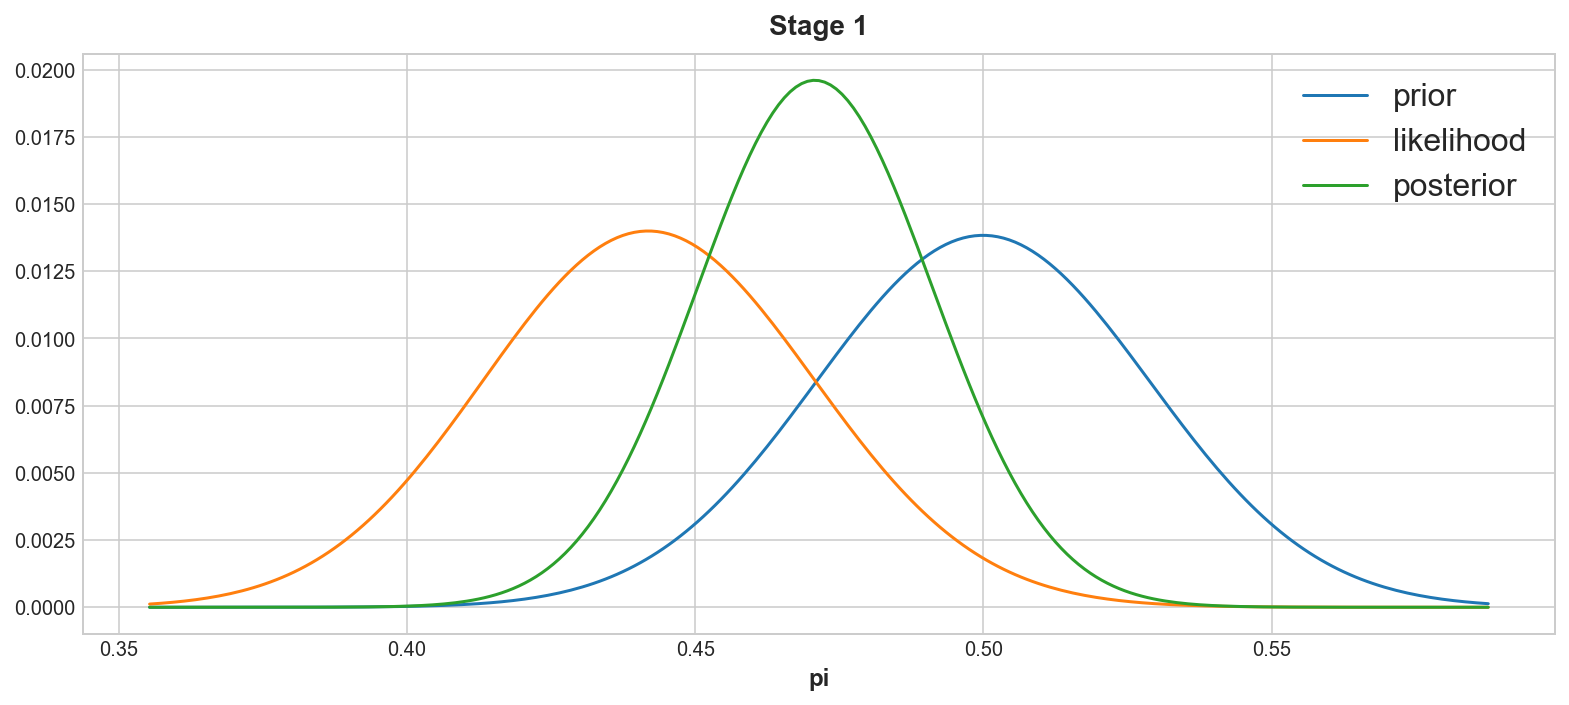

In [266]:
plot_data = bio_bayes_df_stage_1.set_index('pi')[['prior','likelihood','posterior']]

plot_data = plot_data[ plot_data['posterior'] > 0.000000001]

plot_data['prior'] = plot_data['prior'] / sum(plot_data['prior'])
plot_data['likelihood'] = plot_data['likelihood'] / sum(plot_data['likelihood'])


plot_data.plot()

plt.title('Stage 1')

##### (STAGE 2) Tiếp tục tính toán ở giai đoạn 2 từ 8-5-2019 tới 27-9-2021

In [267]:
# tạo dataframe
bio_bayes_df_stage_2 = pd.DataFrame()
# các pi được lựa chọn
bio_bayes_df_stage_2['pi'] = pi_s
# tính prior
bio_bayes_df_stage_2['prior'] = bio_bayes_df_stage_1['posterior']
# tính likelihood
bio_bayes_df_stage_2['likelihood'] = binom.pmf(k=sum(hvn_2['Binominal_Difference']),
n=len(hvn_2['Binominal_Difference']),p=bio_bayes_df_stage_2['pi'])
# tính posterior
bio_bayes_df_stage_2['joint'] =  bio_bayes_df_stage_2['prior'] * bio_bayes_df_stage_2['likelihood']
bio_bayes_df_stage_2['posterior'] = bio_bayes_df_stage_2['joint']  / sum(bio_bayes_df_stage_2['joint'])

bio_bayes_df_stage_2[410:425]

,pi,prior,likelihood,joint,posterior
410,0.410410,0.000228,0.023450,0.000005,0.000743
411,0.411411,0.000265,0.024403,0.000006,0.000897
412,0.412412,0.000306,0.025330,0.000008,0.001077
413,0.413413,0.000353,0.026227,0.000009,0.001287
414,0.414414,0.000407,0.027088,0.000011,0.001530
415,0.415415,0.000467,0.027906,0.000013,0.001809
416,0.416416,0.000535,0.028678,0.000015,0.002129
417,0.417417,0.000610,0.029397,0.000018,0.002492
418,0.418418,0.000695,0.030059,0.000021,0.002903
419,0.419419,0.000790,0.030660,0.000024,0.003364


Đồ thị prior,likelihood và posterior

Text(0.5, 1.0, 'Stage 2')

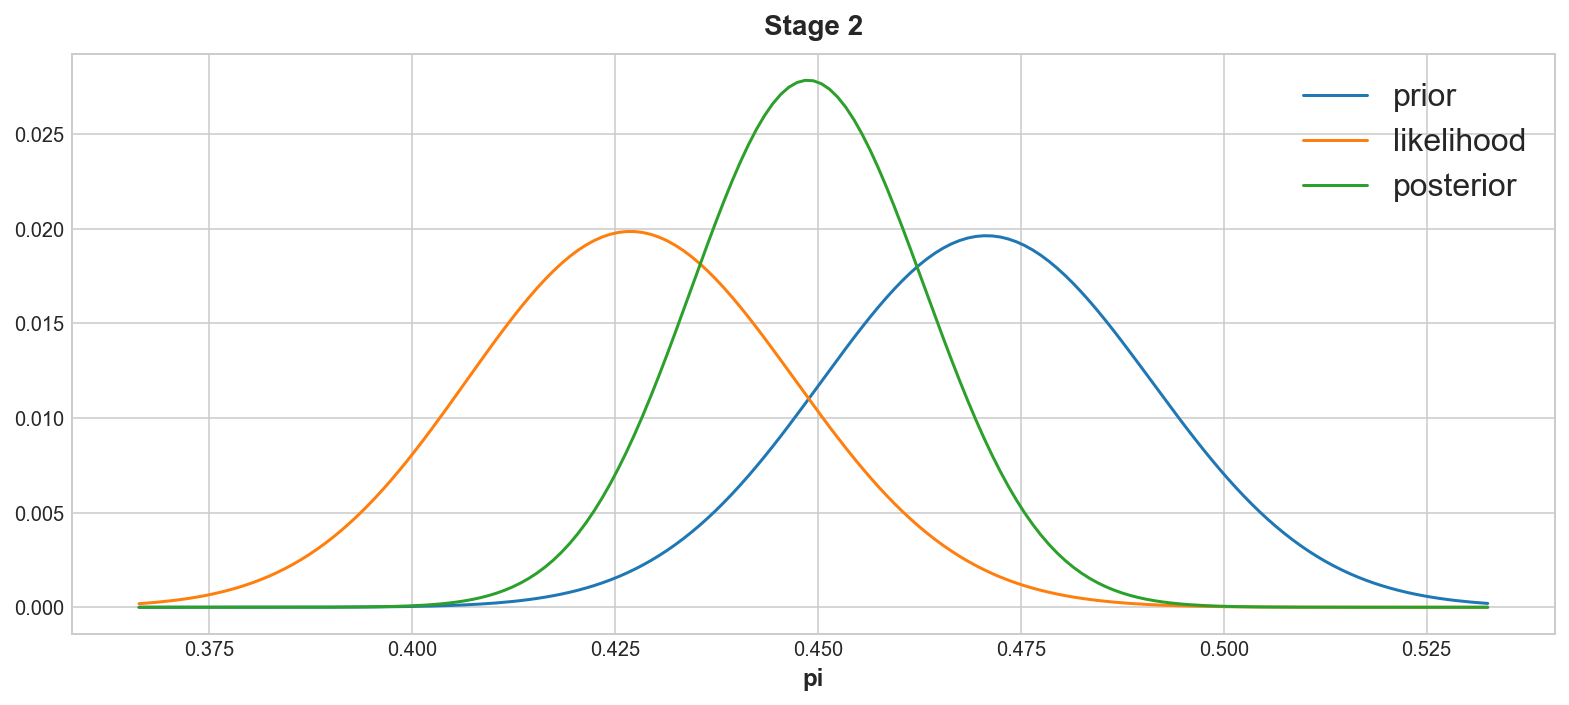

In [268]:
plot_data = bio_bayes_df_stage_2.set_index('pi')[['prior','likelihood','posterior']]
plot_data = plot_data[ plot_data['posterior'] > 0.000000001]
plot_data['prior'] = plot_data['prior'] / sum(plot_data['prior'])
plot_data['likelihood'] = plot_data['likelihood'] / sum(plot_data['likelihood'])
plot_data.plot()

plt.title('Stage 2')

##### (STAGE 3) Cuối cùng tính toán ở giai đoạn 3 từ 8-5-2019 tới 7-12-2022

In [269]:
# tạo dataframe
bio_bayes_df_stage_3= pd.DataFrame()
# các pi được lựa chọn
bio_bayes_df_stage_3['pi'] = pi_s
# tính prior
bio_bayes_df_stage_3['prior'] = bio_bayes_df_stage_2['posterior']
# tính likelihood
bio_bayes_df_stage_3['likelihood'] = binom.pmf(k=sum(hvn_3['Binominal_Difference']),
n=len(hvn_3['Binominal_Difference']),p=bio_bayes_df_stage_3['pi'])
# tính posterior
bio_bayes_df_stage_3['joint'] =  bio_bayes_df_stage_3['prior'] * bio_bayes_df_stage_3['likelihood']
bio_bayes_df_stage_3['posterior'] = bio_bayes_df_stage_3['joint']  / sum(bio_bayes_df_stage_3['joint'])

bio_bayes_df_stage_3[410:425]

,pi,prior,likelihood,joint,posterior
410,0.410410,0.000743,0.018471,0.000014,0.001249
411,0.411411,0.000897,0.019440,0.000017,0.001587
412,0.412412,0.001077,0.020382,0.000022,0.001998
413,0.413413,0.001287,0.021290,0.000027,0.002493
414,0.414414,0.001530,0.022155,0.000034,0.003084
415,0.415415,0.001809,0.022968,0.000042,0.003781
416,0.416416,0.002129,0.023723,0.000051,0.004594
417,0.417417,0.002492,0.024411,0.000061,0.005534
418,0.418418,0.002903,0.025025,0.000073,0.006608
419,0.419419,0.003364,0.025559,0.000086,0.007822


Đồ thị prior,likelihood và posterior

Text(0.5, 1.0, 'Stage 3')

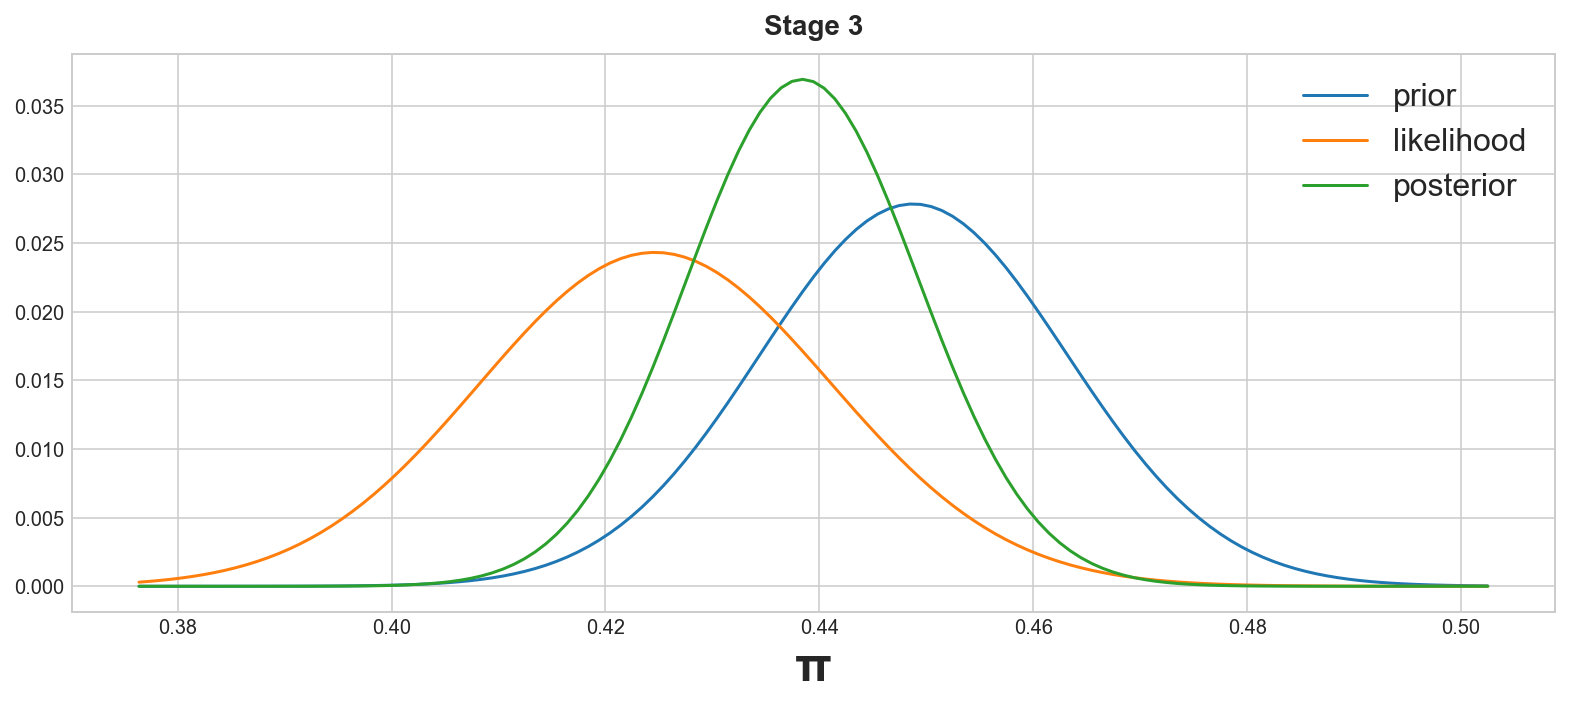

In [270]:
plot_data = bio_bayes_df_stage_3.set_index('pi')[['prior','likelihood','posterior']]

plot_data = plot_data[ plot_data['posterior'] > 0.000000001]

plot_data['prior'] = plot_data['prior'] / sum(plot_data['prior'])
plot_data['likelihood'] = plot_data['likelihood'] / sum(plot_data['likelihood'])


plot_data.plot()
plt.xlabel('π', fontsize=24)


plt.title('Stage 3')

### Đồ thị của Posterior

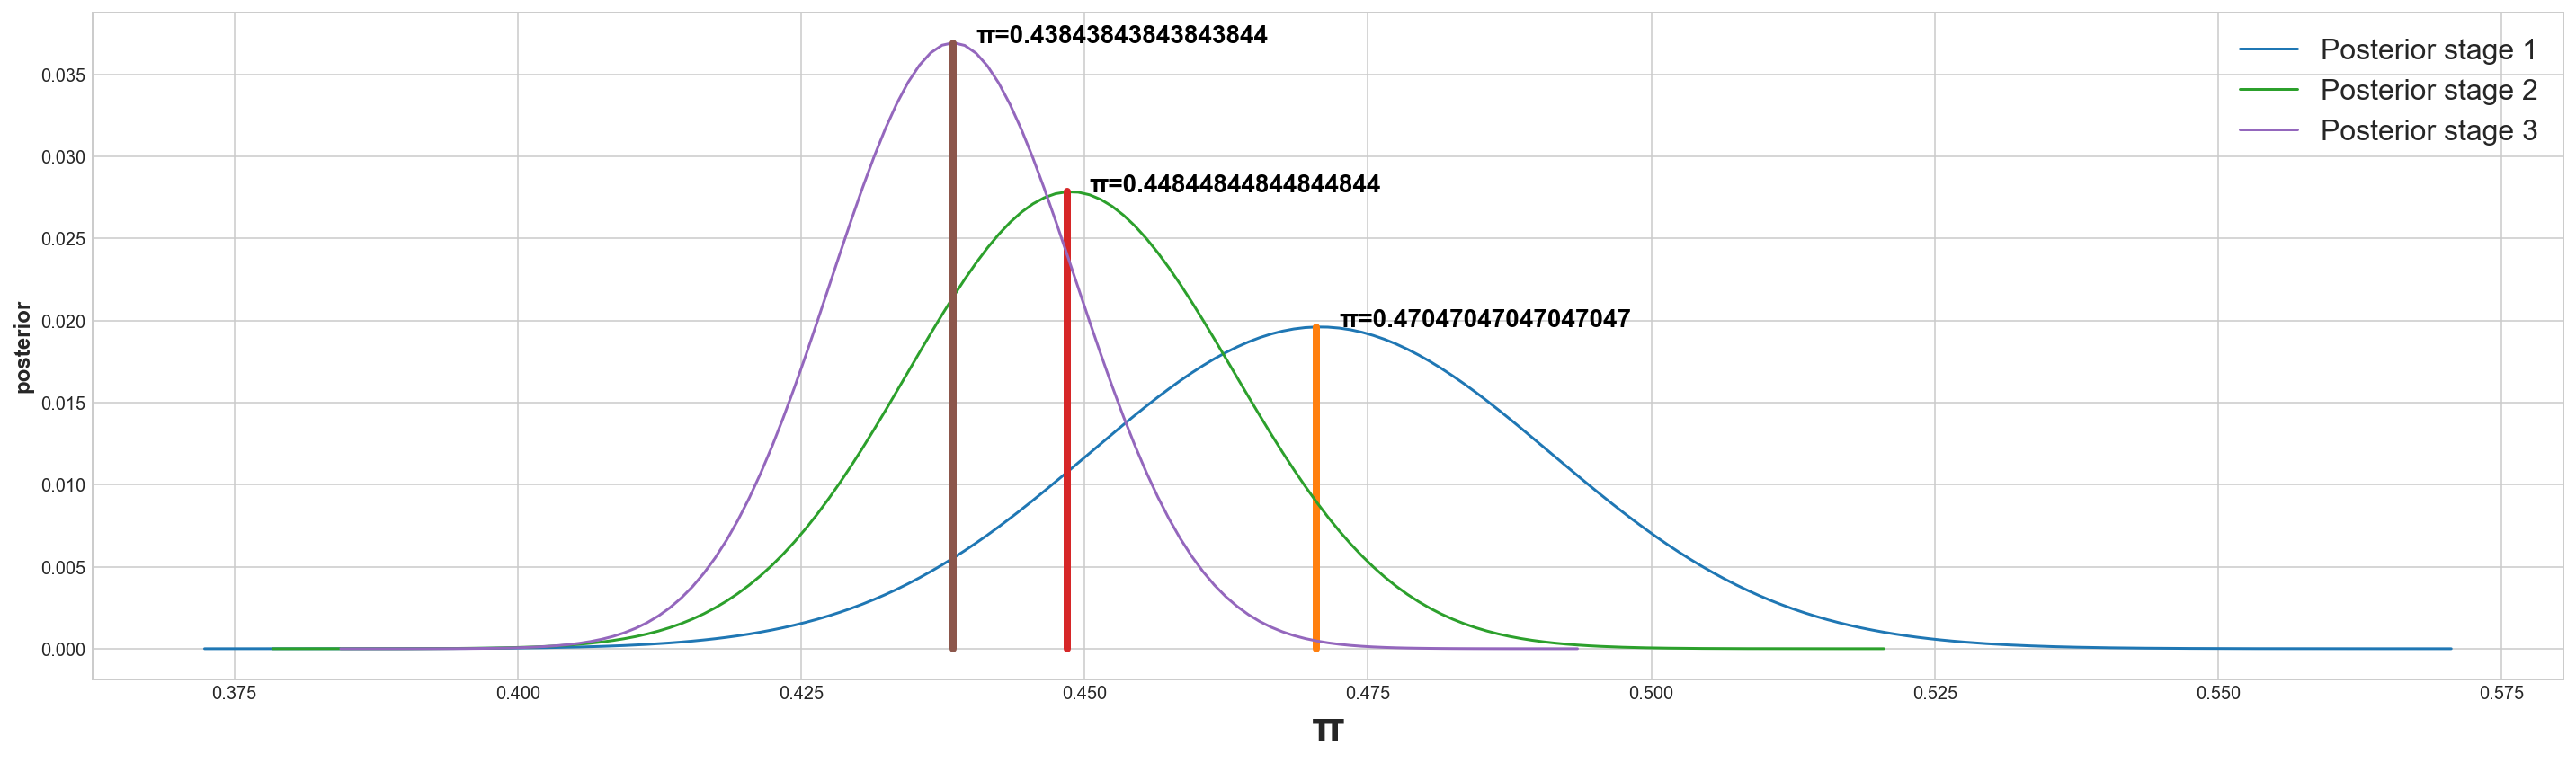

In [271]:
# Plotting all three together
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(20,6))
plt.xlabel('π', fontsize=24)
stages = [bio_bayes_df_stage_1,bio_bayes_df_stage_2,bio_bayes_df_stage_3]

max_pi_list = []

for i in range(0,3): 
     data = stages[i].drop(columns=['joint','likelihood','prior'])
     data = data[data['posterior'] > 0.0000001] 
    
     max_pi = data[data['posterior'] >= data['posterior'].max()] 
     max_pi_list.append(max_pi)

     curr_pi = max_pi['pi'].values[0]
     curr_posterior = max_pi['posterior'].values[0]

     sns.lineplot(x=data['pi'],y=data['posterior'],ax=axes,label='Posterior stage {}'.format(i+1))
     axes.plot([curr_pi,curr_pi],[0,curr_posterior], linewidth=4)
     axes.text(curr_pi + 0.002,curr_posterior,s='π={}'.format(curr_pi),horizontalalignment='left', size='14', color='black', weight='semibold')

plt.rc('legend',fontsize=16)
plt.show()

Qua các giai đoạn phân phối posterior của giai đoạn cuối (3) có xu hướng di chuyển và hội tụ ở π=0.43 ,phương sai nhỏ dần. 
Tính chất giống như thống kê tần suất , với lượng quan sát lớn phương sai sẽ nhỏ dần.

### Khoảng tin cậy (credible interval) và kiểm định


Ở đây nhóm sử dụng chỉ số HDI (high density interval) với mức tin tưởng 90%  thay vì ETI (Equal-tailed Interval) để kiểm tra xem
giá biến động của cổ phiếu HVN có khả năng ở mức nào.

In [272]:
# tính hdi
[hdi_lower, hdi_upper] = hdi(bio_bayes_df_stage_3['pi'],bio_bayes_df_stage_3['posterior']) 
print("Cận dưới HDI {} \nCận trên HDI {}".format(hdi_lower,hdi_upper))

Cận dưới HDI 0.42042042042042044 
Cận trên HDI 0.45645645645645644


Text(0.5, 0, 'π')

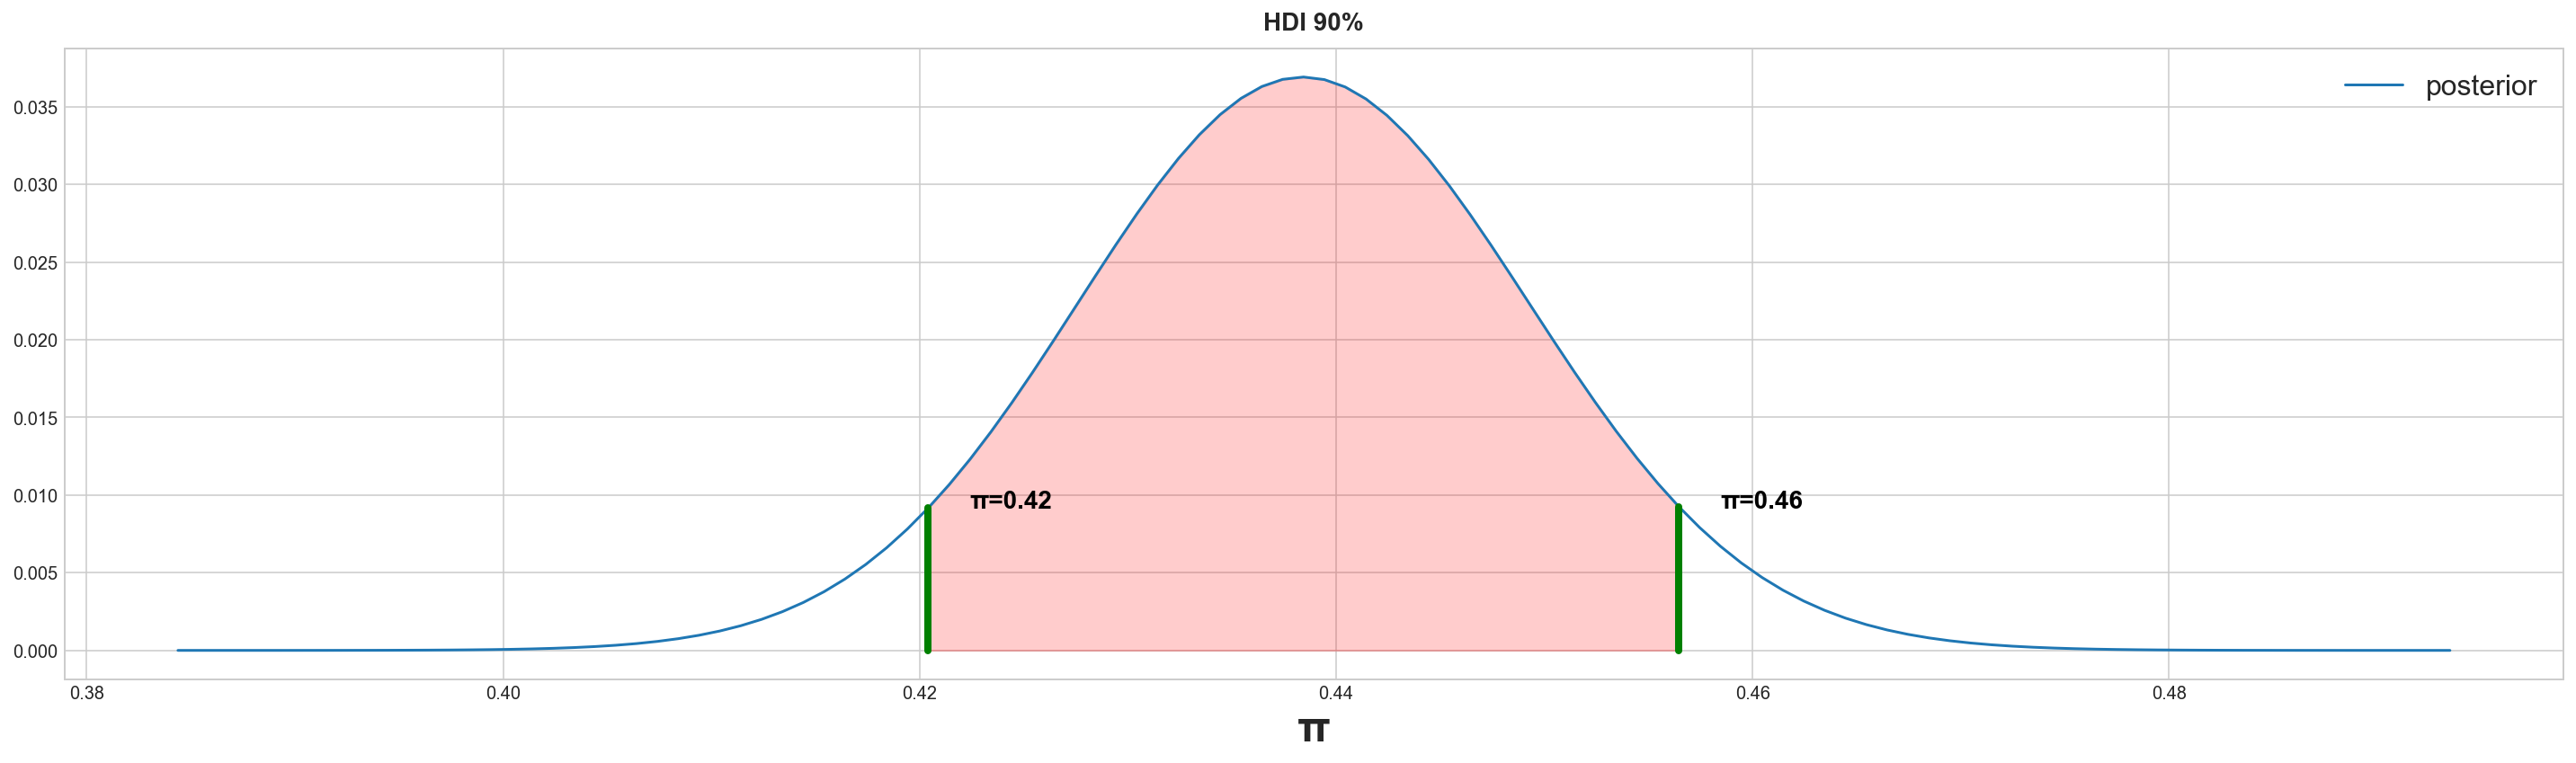

In [273]:
plot_data = bio_bayes_df_stage_3.set_index('pi')[['posterior']]
plot_data = plot_data[plot_data['posterior'] > 0.0000001]

plot_data = plot_data.sort_values(by='pi')

fill_data = plot_data[plot_data.index >= hdi_lower]

fill_data = fill_data[fill_data.index <= hdi_upper]

hdi_lower_prob = fill_data[fill_data.index == hdi_lower].iloc[0,:]['posterior']

hdi_upper_prob = fill_data[fill_data.index == hdi_upper].iloc[0,:]['posterior']

fig, axes = plt.subplots(1, 1, sharex=True, figsize=(20,6))

axes.fill_between(fill_data.index,fill_data['posterior'],alpha=0.2,color='red')
plt.title('HDI 90%')
plot_data.plot(ax=axes)
# chú thích cho HDI 
axes.plot([hdi_lower,hdi_lower],[0,hdi_lower_prob], linewidth=4,color='green')
axes.plot([hdi_upper,hdi_upper],[0,hdi_upper_prob], linewidth=4,color='green')
axes.text(hdi_lower + 0.002,hdi_lower_prob,s='π={}'.format(np.round(hdi_lower,2)),horizontalalignment='left', size='14', color='black', weight='semibold')
axes.text(hdi_upper + 0.002,hdi_lower_prob,s='π={}'.format(np.round(hdi_upper,2)),horizontalalignment='left', size='14', color='black', weight='semibold')

plt.xlabel('π', fontsize=24)


Kỉểm đinh giá trị của π cặp giả thuyết
- H0: π = 0.5
- H1: π != 0.5 
- Ta có π nằm ngoài miền HDI cho nên  bác bỏ H0 kết luận π khác 0.5


Kiểm định khoảng với cặp giả thuyết với độ tin cậy 90%
- H0: π <= 0.40
- H1: π > 0.45

In [274]:
# Tính suát xuất tích lũy của posterior với μ <= -100
hypothesis_df = bio_bayes_df_stage_3[['pi','posterior']].sort_values(by='pi')
p_value = sum(hypothesis_df[hypothesis_df['pi'] <= 0.4]['posterior'])
p_value <= 0.05

True

p_value bé hơn 5% cho nên bắc bỏ H0 chấp nhận H1 π > 0.45

----
##  Phân tích bayes trên bộ dữ liệu phân ở dạng phân phối poisson

###  Chuyển dữ liệu qua phân phân phối Poisson

In [275]:
hvn_resample = hvn[['Binominal_Difference']].copy()
hvn_resample = hvn_resample.resample('W', convention='end').sum()
hvn_resample.columns = ['up_day_in_week']
hvn_resample[:10]

,up_day_in_week
Time,
2019-05-12,0
2019-05-19,2
2019-05-26,5
2019-06-02,3
2019-06-09,3
2019-06-16,4
2019-06-23,3
2019-06-30,1
2019-07-07,1


Dữ liệu đã được chuyển từ phân phối nhị thức sang Poisson bằng cách lấy tổng trong vòng 7 ngày của của phân phối nhị thức.

In [276]:
print('Phân phối Poisson với trung bình : {} '.format(hvn_resample['up_day_in_week'].mean()))
print('Phân phối Poisson thức với độ lệch chuẩn: {} '.format(hvn_resample['up_day_in_week'].std()))

Phân phối Poisson với trung bình : 2.0372340425531914 
Phân phối Poisson thức với độ lệch chuẩn: 1.0962731267620198 


<AxesSubplot:xlabel='up_day_in_week', ylabel='Count'>

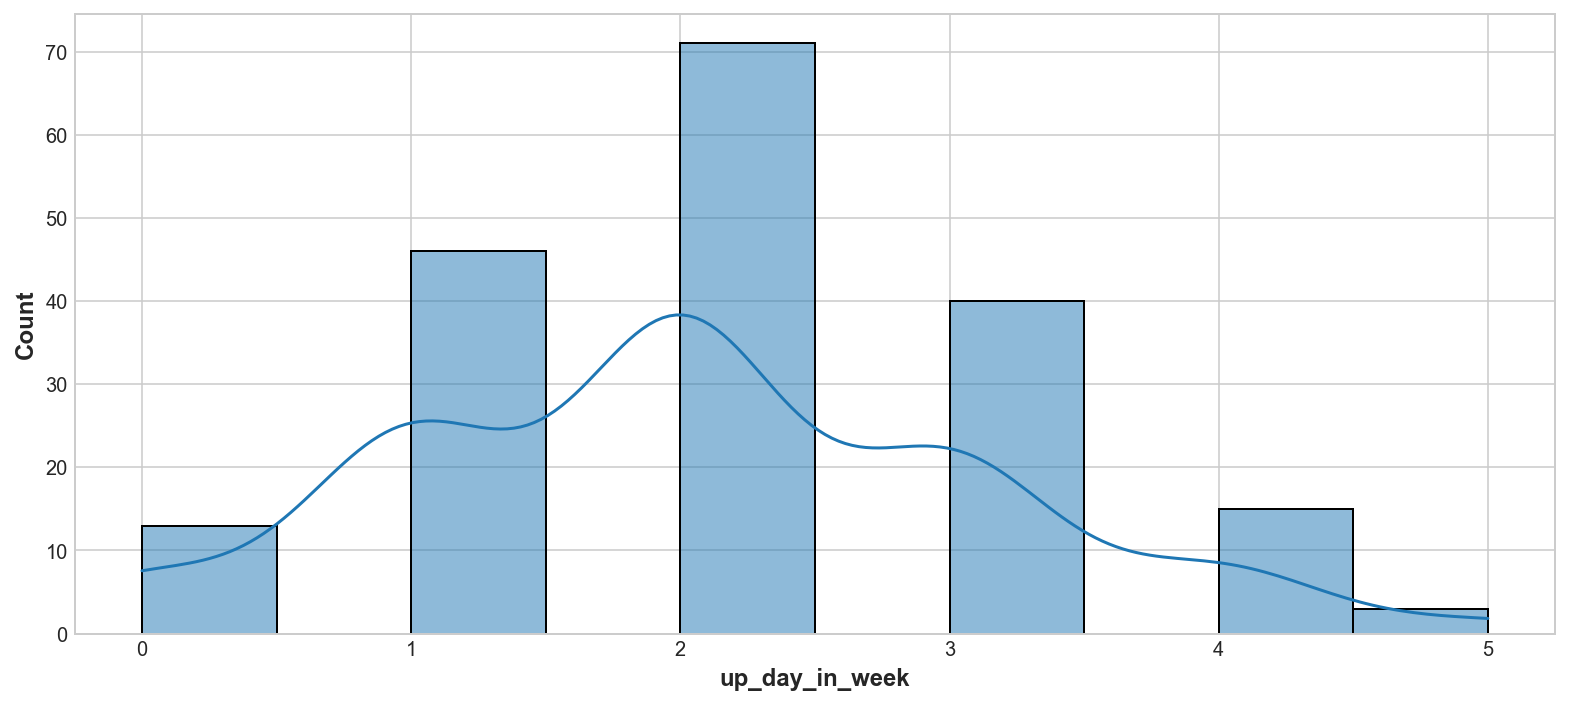

In [277]:
sns.histplot(hvn_resample['up_day_in_week'],kde=True,bins=10)

Ý nghĩa là số ngày tăng giá trọng một tuần của HVN, với trung bình là mỗi tuần HVN sẽ có 2 ngày tăng giá. Số ngày tăng giá trong tuần cao nhất là 5 và thấp nhất là 0 tức không có ngày nào trong tuần cổ phiếu có sự tăng giá.


### Phân tích bayes cho số ngày tăng giá trọng một tuần của HVN
Ở đây ta sẽ bộ dữ liệu thành 3 phần sau đó dùng posterior ở cuối mỗi giai đoạn làm đầu vào 
prior cho giai đoạn tiếp theo. ![](./src/intro.png)

In [278]:
hvn_resample_1 = hvn_resample[0:301]
hvn_resample_2 = hvn_resample[0:602]
hvn_resample_3 = hvn_resample[0:903]

In [279]:
print('Trung bình của giai đoạn 1: {} '.format(hvn_resample_1['up_day_in_week'].mean()))
print('Dộ lệch chuẩn của giai đoạn 1: {} '.format(hvn_resample_1['up_day_in_week'].std()))

Trung bình của giai đoạn 1: 2.0372340425531914 
Dộ lệch chuẩn của giai đoạn 1: 1.0962731267620198 


Xem bộ dữ liệu giai đoạn 1 từ 8-5-2019 tới 15-7-2020 có trung bình 2.03 và phương sai  
là 1.09^2 
- Do bộ dữ liệu của chúng là phân phối Poisson cho nên nhóm sẽ chọn đầu tiên nghiệm (prior)
là phân phối Gamma với trung bình bằng 2 và phương sai là 1.09^2 tương ứng với cách hệ số r và v được xác định bởi công thức:
![](./src/3.png)
- Giá trị các trung bình (μ) sẽ là rời rạc trong khoảng từ  2 +  âm độ lệch chuẩn * 1.196 đến  2  + dương độ lệch chuẩn * 1.96. Được chia thành 
1000 điểm cách đều nhau bằng hàm linespace.
- **Prior** sẽ được tính bằng hàm mật độ xác suất (pdf) của phân phối Gamma(r,v).
- **Likelihood** ssẽ được tính bằng hàm mật độ xác suất (pdf) của phân phối Gamma(r',v') với r' và v' được xác định như sau:
![](./src/4.png)
- **Posterior** sẽ được tính toán thủ công, không sử dụng công thức của tiên nghiệm liên hợp.

##### (STAGE 1) Khởi tạo các tham số ở giai đoạn 1 từ 8-5-2019 tới 15-7-2020

In [280]:
m = hvn_resample_1['up_day_in_week'].mean()
s = hvn_resample_1['up_day_in_week'].std()

# tính v và r
r = (m**2 / s**2)
v = (m / s**2)
# tạo các giá trị mu đầu vào
mu  = np.linspace(m - 1.96 *s,m + 1.96 *s,1000)

In [281]:
# tính v' và r'
r_comma = sum(hvn_resample_1['up_day_in_week']) + 1
v_comma = len(hvn_resample_1['up_day_in_week'])

# tạo dataframe
pos_bayes_df_stage_1  = pd.DataFrame()
pos_bayes_df_stage_1['mu'] = mu
# tính prior
pos_bayes_df_stage_1['prior'] = gamma.pdf(x=pos_bayes_df_stage_1['mu'],a=r,scale=1/v)
# tính likelihood
pos_bayes_df_stage_1['likelihood'] = gamma.pdf(x=pos_bayes_df_stage_1['mu'],a=r_comma,scale=1/v_comma)
# tính posterior
pos_bayes_df_stage_1['joint'] =  pos_bayes_df_stage_1['prior'] * pos_bayes_df_stage_1['likelihood']
pos_bayes_df_stage_1['posterior'] = pos_bayes_df_stage_1['joint']  / sum(pos_bayes_df_stage_1['joint'])

Đồ thị prior,likelihood và posterior

Text(0.5, 0, 'μ')

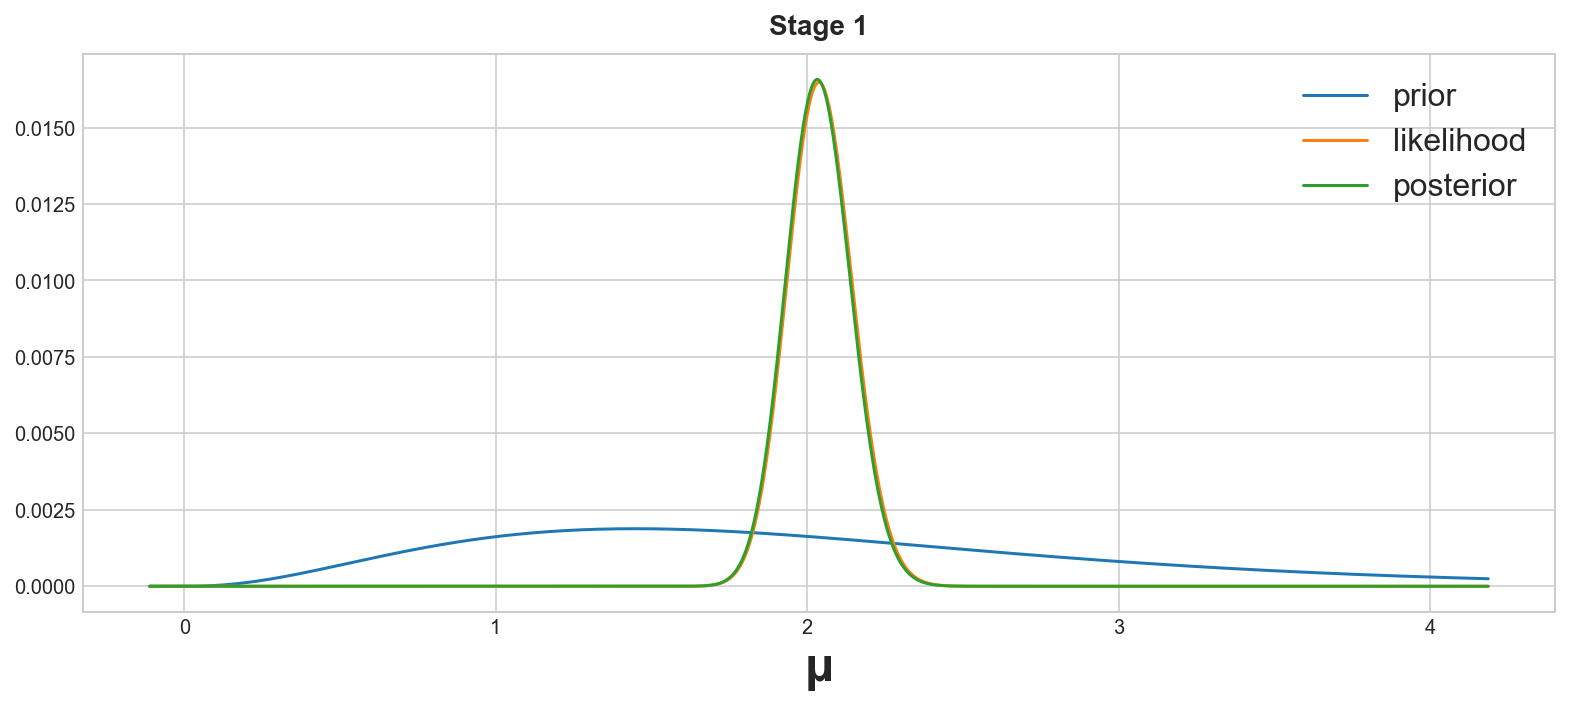

In [282]:
plot_data = pos_bayes_df_stage_1.set_index('mu')[['prior','likelihood','posterior']]

plot_data['prior'] = plot_data['prior'] / sum(plot_data['prior'])
plot_data['likelihood'] = plot_data['likelihood'] / sum(plot_data['likelihood'])
plot_data.plot()
plt.title('Stage 1')
plt.xlabel('μ', fontsize=24)

##### (STAGE 2) Tiếp tục tính toán ở giai đoạn 2 từ 8-5-2019 tới 27-9-2021

In [283]:
# tính v' và r'
r_comma = sum(hvn_resample_2['up_day_in_week']) + 1
v_comma = len(hvn_resample_2['up_day_in_week'])

# tạo dataframe
pos_bayes_df_stage_2 = pd.DataFrame()
# các pi được lựa chọn
pos_bayes_df_stage_2['mu'] = mu
# tính prior
pos_bayes_df_stage_2['prior'] = pos_bayes_df_stage_1['posterior']
# tính likelihood
pos_bayes_df_stage_2['likelihood'] =  gamma.pdf(x=pos_bayes_df_stage_2['mu'],a=r_comma,scale=1/v_comma)
# tính posterior
pos_bayes_df_stage_2['joint'] =  pos_bayes_df_stage_2['prior'] * pos_bayes_df_stage_2['likelihood']
pos_bayes_df_stage_2['posterior'] = pos_bayes_df_stage_2['joint']  / sum(pos_bayes_df_stage_2['joint'])

pos_bayes_df_stage_2[410:425]

,mu,prior,likelihood,joint,posterior
410,1.652233,0.000007,0.001501,1.118077e-08,4.118005e-09
411,1.656534,0.000009,0.001810,1.624173e-08,5.982016e-09
412,1.660836,0.000011,0.002176,2.347160e-08,8.644857e-09
413,1.665138,0.000013,0.002611,3.374535e-08,1.242880e-08
414,1.669439,0.000015,0.003124,4.826786e-08,1.777760e-08
415,1.673741,0.000018,0.003729,6.868884e-08,2.529888e-08
416,1.678043,0.000022,0.004439,9.725455e-08,3.581996e-08
417,1.682344,0.000026,0.005271,1.370063e-07,5.046097e-08
418,1.686646,0.000031,0.006244,1.920388e-07,7.073008e-08
419,1.690948,0.000036,0.007378,2.678346e-07,9.864653e-08


Text(0.5, 0, 'μ')

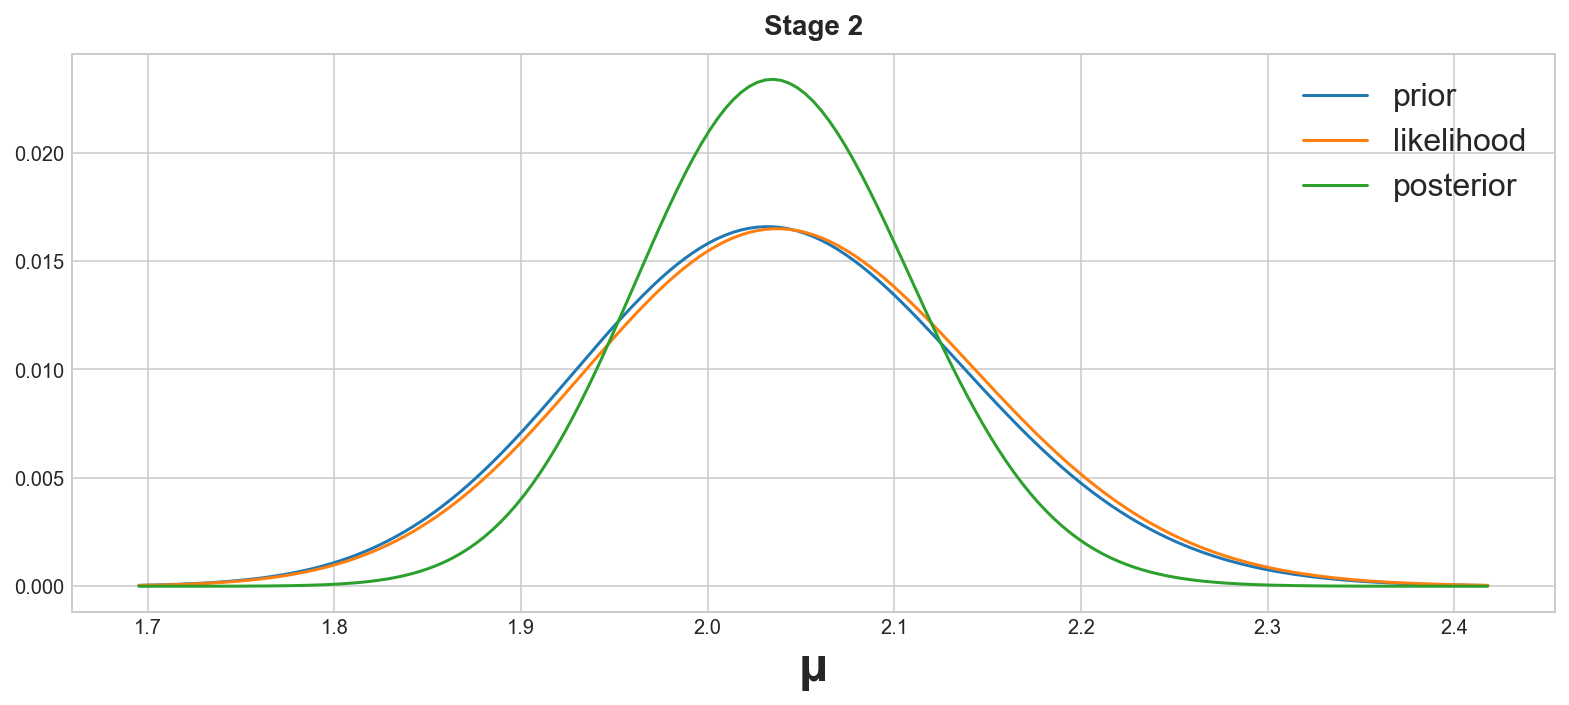

In [284]:
plot_data = pos_bayes_df_stage_2.set_index('mu')[['prior','likelihood','posterior']]
plot_data = plot_data[plot_data['posterior'] > 0.0000001]
plot_data['prior'] = plot_data['prior'] / sum(plot_data['prior'])
plot_data['likelihood'] = plot_data['likelihood'] / sum(plot_data['likelihood'])
plot_data.plot()
plt.title('Stage 2')
plt.xlabel('μ', fontsize=24)

##### (STAGE 3) Cuối cùng tính toán ở giai đoạn 3 từ 8-5-2019 tới 27-9-2021

In [285]:
# tính v' và r'
r_comma = sum(hvn_resample_3['up_day_in_week']) + 1
v_comma = len(hvn_resample_3['up_day_in_week'])

# tạo dataframe
pos_bayes_df_stage_3= pd.DataFrame()
# các pi được lựa chọn
pos_bayes_df_stage_3['mu'] = mu
# tính prior
pos_bayes_df_stage_3['prior'] = pos_bayes_df_stage_2['posterior']
# tính likelihood
pos_bayes_df_stage_3['likelihood'] =  gamma.pdf(x=pos_bayes_df_stage_3['mu'],a=r_comma,scale=1/v_comma)
# tính posterior
pos_bayes_df_stage_3['joint'] =  pos_bayes_df_stage_3['prior'] * pos_bayes_df_stage_3['likelihood']
pos_bayes_df_stage_3['posterior'] = pos_bayes_df_stage_3['joint']  / sum(pos_bayes_df_stage_3['joint'])

pos_bayes_df_stage_3[410:425]

,mu,prior,likelihood,joint,posterior
410,1.652233,4.118005e-09,0.001501,6.180210e-12,1.974083e-12
411,1.656534,5.982016e-09,0.001810,1.082536e-11,3.457838e-12
412,1.660836,8.644857e-09,0.002176,1.881524e-11,6.009963e-12
413,1.665138,1.242880e-08,0.002611,3.245055e-11,1.036535e-11
414,1.669439,1.777760e-08,0.003124,5.553887e-11,1.774023e-11
415,1.673741,2.529888e-08,0.003729,9.433042e-11,3.013102e-11
416,1.678043,3.581996e-08,0.004439,1.590023e-10,5.078850e-11
417,1.682344,5.046097e-08,0.005271,2.659920e-10,8.496316e-11
418,1.686646,7.073008e-08,0.006244,4.416358e-10,1.410673e-10
419,1.690948,9.864653e-08,0.007378,7.277919e-10,2.324713e-10


Text(0.5, 0, 'μ')

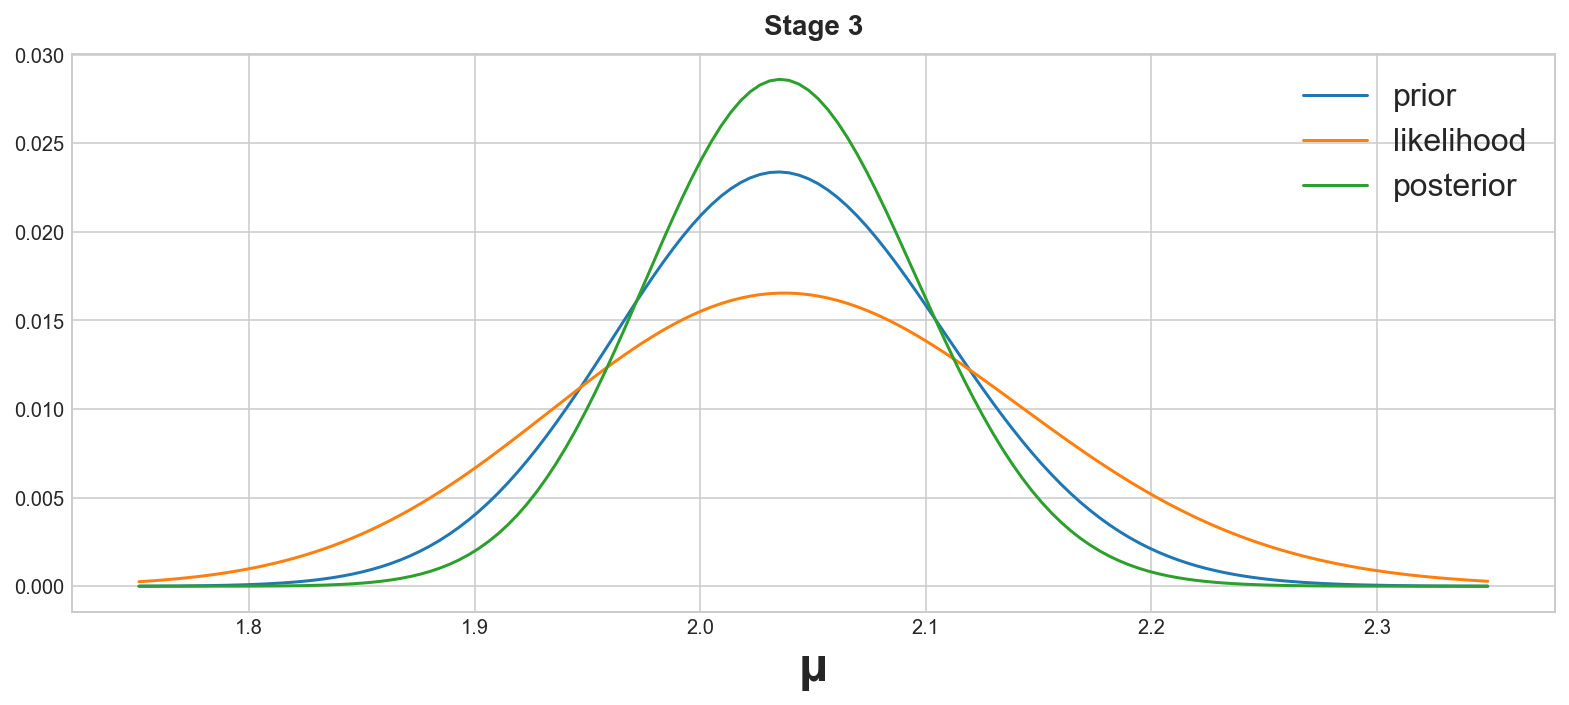

In [286]:
plot_data = pos_bayes_df_stage_3.set_index('mu')[['prior','likelihood','posterior']]
plot_data = plot_data[plot_data['posterior'] > 0.0000001]
plot_data['prior'] = plot_data['prior'] / sum(plot_data['prior'])
plot_data['likelihood'] = plot_data['likelihood'] / sum(plot_data['likelihood'])
plot_data.plot()
plt.title('Stage 3')
plt.xlabel('μ', fontsize=24)

### Đồ thị của Posterior

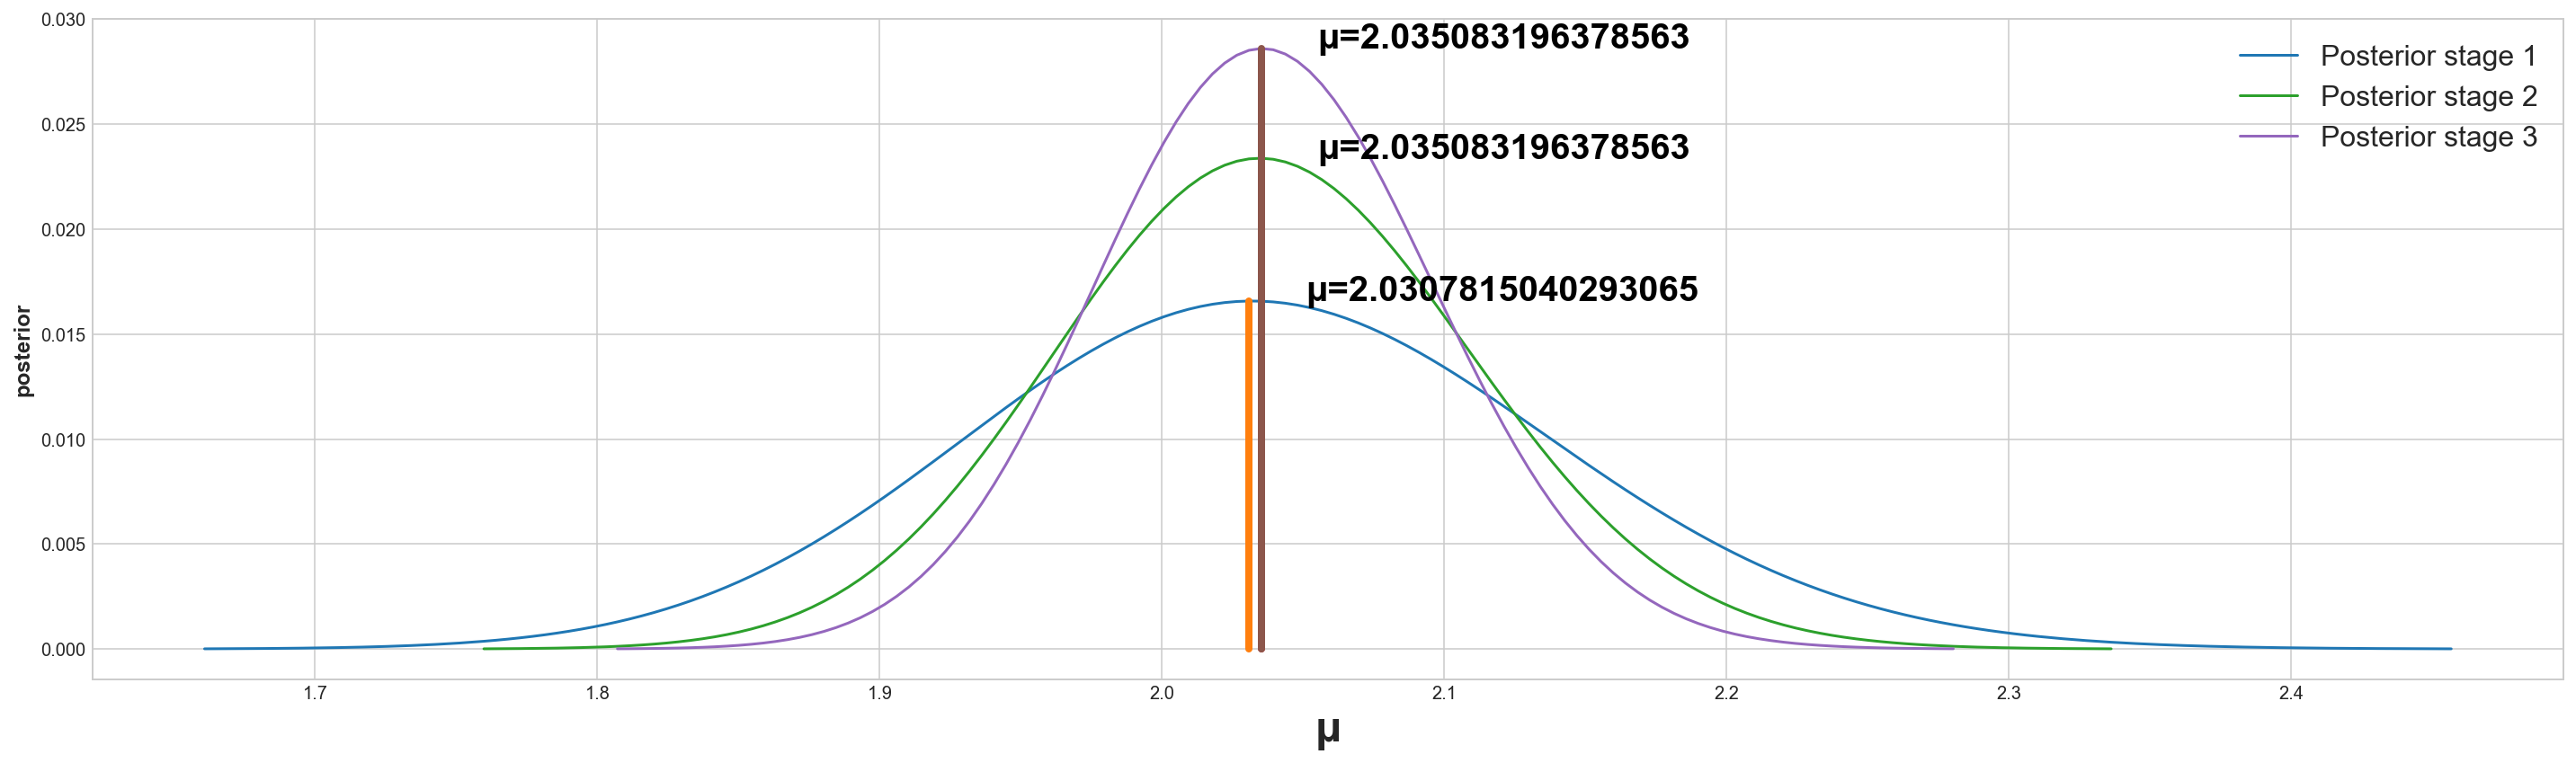

In [287]:
# Plotting all three together
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(20,6))
plt.xlabel('μ', fontsize=24)
stages = [pos_bayes_df_stage_1,pos_bayes_df_stage_2,pos_bayes_df_stage_3]

max_mu_list = []

for i in range(0,3): 
     data = stages[i].drop(columns=['joint','likelihood','prior'])
     data = data[data['posterior'] > 0.00001] 
    
     max_mu = data[data['posterior'] >= data['posterior'].max()] 
     max_mu_list.append(max_mu)

     curr_mu = max_mu['mu'].values[0]
     curr_posterior = max_mu['posterior'].values[0]

     sns.lineplot(x=data['mu'],y=data['posterior'],ax=axes,label='Posterior stage {}'.format(i+1))
     axes.plot([curr_mu,curr_mu],[0,curr_posterior], linewidth=4, )
     axes.text(curr_mu + 0.02,curr_posterior,s='μ={}'.format(curr_mu),horizontalalignment='left', size='20', color='black', weight='semibold')

plt.rc('legend',fontsize=16)
plt.show()

*Các giá trị μ ở xa 0 tức 2 đuôi có giá trị xác xuất quá thấp nên đã bị loại ra khỏi đồ thị.* 
 
Qua các giai đoạn phân phối posterior của giai đoạn cuối (3) có xu hướng di chuyển và hội tụ ở trung bình 2.03 ,phương sai nhỏ dần, điều đặc biệt là trung bình không có sư di chuyển mạnh như 2 phân phối chuẩn và phân phối 
nhị thức. 
 
Tính chất giống như thống kê tần suất , với lượng quan sát lớn phương sai sẽ nhỏ dần.

### Khoảng tin cậy (credible interval) và kiểm định

Ở đây nhóm sử dụng chỉ số HDI (high density interval) với mức tin tưởng 90%  thay vì ETI (Equal-tailed Interval) để kiểm tra xem
số ngày tăng giá trong tuần  của cổ phiếu HVN có khả năng ở mức nào.

In [288]:
# tính hdi
[hdi_lower, hdi_upper] = hdi(pos_bayes_df_stage_3['mu'],pos_bayes_df_stage_3['posterior']) 
print("Cận dưới HDI {} \nCận trên HDI {}".format(hdi_lower,hdi_upper))

Cận dưới HDI 1.9361442723456666 
Cận trên HDI 2.1340221204114598


Text(0.5, 0, 'μ')

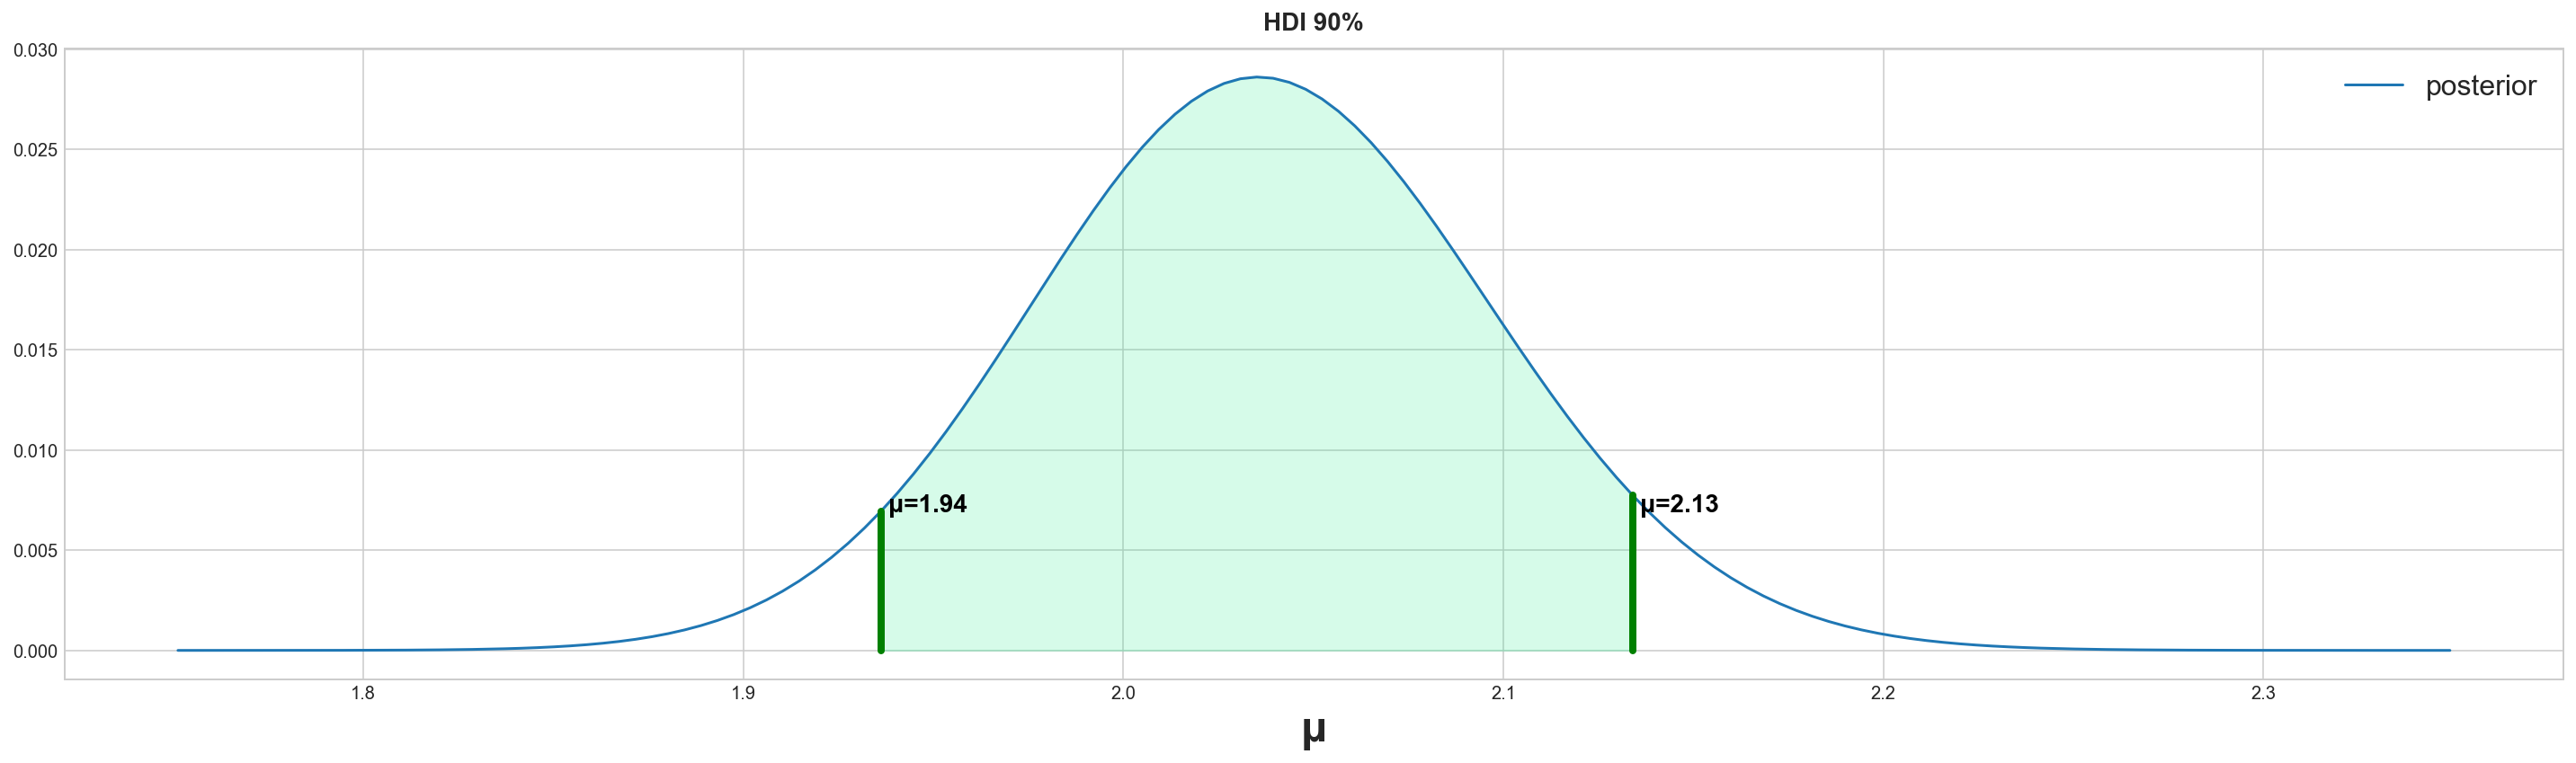

In [289]:
plot_data = pos_bayes_df_stage_3.set_index('mu')[['posterior']]
plot_data = plot_data[plot_data['posterior'] > 0.0000001]

plot_data = plot_data.sort_values(by='mu')

fill_data = plot_data[plot_data.index >= hdi_lower]

fill_data = fill_data[fill_data.index <= hdi_upper]

hdi_lower_prob = fill_data[fill_data.index == hdi_lower].iloc[0,:]['posterior']

hdi_upper_prob = fill_data[fill_data.index == hdi_upper].iloc[0,:]['posterior']

fig, axes = plt.subplots(1, 1, sharex=True, figsize=(20,6))

axes.fill_between(fill_data.index,fill_data['posterior'],alpha=0.2,color='#33eb91')
plt.title('HDI 90%')
plot_data.plot(ax=axes)
# chú thích cho HDI 
axes.plot([hdi_lower,hdi_lower],[0,hdi_lower_prob], linewidth=4,color='green')
axes.plot([hdi_upper,hdi_upper],[0,hdi_upper_prob], linewidth=4,color='green')
axes.text(hdi_lower + 0.002,hdi_lower_prob,s='μ={}'.format(np.round(hdi_lower,2)),horizontalalignment='left', size='14', color='black', weight='semibold')
axes.text(hdi_upper + 0.002,hdi_lower_prob,s='μ={}'.format(np.round(hdi_upper,2)),horizontalalignment='left', size='14', color='black', weight='semibold')

plt.xlabel('μ', fontsize=24)


Kỉểm đinh giá trị của μ cặp giả thuyết
- H0: μ = 1.9
- H1: μ != 1.9  
- Ta có μ nằm ngoài miền HDI cho nên bác bỏ H0 kết luận μ != 1.9


Kiểm định khoảng với cặp giả thuyết với độ tin cậy 90%
- H0: μ <= 1.9
- H1: μ > 1.9

In [290]:
# Tính suát xuất tích lũy của posterior với μ <= 1.9
hypothesis_df = norm_bayes_df_stage_3[['mu','posterior']].sort_values(by='mu')
p_value = sum(hypothesis_df[hypothesis_df['mu'] <= -1.9]['posterior'])
p_value <= 0.05


False

p_value lớn hơn 5% cho nên không bác bỏ H0 chấp nhận  μ <= 1.9